Importing necessary libraries

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [6]:
import warnings
warnings.filterwarnings("ignore")

**Data Ingestion**

In [7]:
# mount the data set
from google.colab import drive
drive.mount('/content/drive')
user_file_path='/content/drive/MyDrive/travel_capstone/data/users.csv'
hotel_file_path='/content/drive/MyDrive/travel_capstone/data/hotels.csv'
flights_file_path='/content/drive/MyDrive/travel_capstone/data/flights.csv'

Mounted at /content/drive


In [8]:
flight_df=pd.read_csv(flights_file_path)
hotel_df=pd.read_csv(hotel_file_path,on_bad_lines='skip')
user_df=pd.read_csv(user_file_path,on_bad_lines='skip')

In [9]:
flight_df.head()

,travelCode,userCode,from,to,flightType,price,time,distance,agency,date
0,0,0,Recife (PE),Florianopolis (SC),firstClass,1434.38,1.76,676.53,FlyingDrops,09/26/2019
1,0,0,Florianopolis (SC),Recife (PE),firstClass,1292.29,1.76,676.53,FlyingDrops,09/30/2019
2,1,0,Brasilia (DF),Florianopolis (SC),firstClass,1487.52,1.66,637.56,CloudFy,10/03/2019
3,1,0,Florianopolis (SC),Brasilia (DF),firstClass,1127.36,1.66,637.56,CloudFy,10/04/2019
4,2,0,Aracaju (SE),Salvador (BH),firstClass,1684.05,2.16,830.86,CloudFy,10/10/2019


Create a function price/km and apply it in dataframe and create new column

In [10]:
def price_km(x,y):
  price_per_km=x/y

  return price_per_km

In [11]:
flight_df.apply

<bound method DataFrame.apply of         travelCode  userCode                 from                   to  \
0                0         0          Recife (PE)   Florianopolis (SC)   
1                0         0   Florianopolis (SC)          Recife (PE)   
2                1         0        Brasilia (DF)   Florianopolis (SC)   
3                1         0   Florianopolis (SC)        Brasilia (DF)   
4                2         0         Aracaju (SE)        Salvador (BH)   
...            ...       ...                  ...                  ...   
271883      135941      1339    Campo Grande (MS)   Florianopolis (SC)   
271884      135942      1339   Florianopolis (SC)           Natal (RN)   
271885      135942      1339           Natal (RN)   Florianopolis (SC)   
271886      135943      1339   Florianopolis (SC)  Rio de Janeiro (RJ)   
271887      135943      1339  Rio de Janeiro (RJ)   Florianopolis (SC)   

        flightType    price  time  distance       agency        date  
0       firstClass  1434.38  1.76    676.53  FlyingDrops  09/26/2019  
1       firstClass  1292.29  1.76    676.53  FlyingDrops  09/30/2019  
2       firstClass  1487.52  1.66    637.56      CloudFy  10/03/2019  
3       firstClass  1127.36  1.66    637.56      CloudFy  10/04/2019  
4       firstClass  1684.05  2.16    830.86      CloudFy  10/10/2019  
...            ...      ...   ...       ...          ...         ...  
271883  firstClass  1446.34  1.49    573.81      CloudFy  07/12/2020  
271884    economic   726.95  1.84    709.37      CloudFy  07/16/2020  
271885    economic   873.07  1.84    709.37      CloudFy  07/20/2020  
271886    economic   313.62  1.21    466.30      CloudFy  07/23/2020  
271887    economic   533.69  1.21    466.30      CloudFy  07/26/2020  

[271888 rows x 10 columns]>

**Data Mining and Exploration**

In [12]:
# Total no. of rows in the dataset

df_list=[flight_df,hotel_df,user_df]
df_name_list=['flight_df','hotel_df','user_df']

for i in df_name_list:
  if i == 'flight_df':
    print(f'Total no. of rows in {i}: {len(df_list[0])}')
  elif i == 'hotel_df':
    print(f'Total no. of rows in {i}: {len(df_list[1])}')
  else:
    print(f'Total no. of rows in user_df: {len(df_list[2])}')

Total no. of rows in flight_df: 271888
Total no. of rows in hotel_df: 40552
Total no. of rows in user_df: 1340


In [13]:
# Overall Information of Dataset

for i in df_name_list:
  if i == 'flight_df':
    print(f'Information about {i}')
    print(df_list[0].info())
  elif i == 'hotel_df':
    print(f'Information about {i}')
    print(df_list[1].info())
  else:
    print(f'Information about {i}')
    print(df_list[2].info())

Information about flight_df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271888 entries, 0 to 271887
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   travelCode  271888 non-null  int64  
 1   userCode    271888 non-null  int64  
 2   from        271888 non-null  object 
 3   to          271888 non-null  object 
 4   flightType  271888 non-null  object 
 5   price       271888 non-null  float64
 6   time        271888 non-null  float64
 7   distance    271888 non-null  float64
 8   agency      271888 non-null  object 
 9   date        271888 non-null  object 
dtypes: float64(3), int64(2), object(5)
memory usage: 20.7+ MB
None
Information about hotel_df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40552 entries, 0 to 40551
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   travelCode  40552 non-null  int64  
 1   userCode    40552 non-null

In [14]:
# Overall Information of Dataset

for i in df_name_list:
  if i == 'flight_df':
    print(f'Information about {i}')
    print(df_list[0].info())
  elif i == 'hotel_df':
    print(f'Information about {i}')
    print(df_list[1].info())
  else:
    print(f'Information about {i}')
    print(df_list[2].info())

Information about flight_df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271888 entries, 0 to 271887
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   travelCode  271888 non-null  int64  
 1   userCode    271888 non-null  int64  
 2   from        271888 non-null  object 
 3   to          271888 non-null  object 
 4   flightType  271888 non-null  object 
 5   price       271888 non-null  float64
 6   time        271888 non-null  float64
 7   distance    271888 non-null  float64
 8   agency      271888 non-null  object 
 9   date        271888 non-null  object 
dtypes: float64(3), int64(2), object(5)
memory usage: 20.7+ MB
None
Information about hotel_df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40552 entries, 0 to 40551
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   travelCode  40552 non-null  int64  
 1   userCode    40552 non-null

In [15]:
flight_df.describe(include='object')

,from,to,flightType,agency,date
count,271888,271888,271888,271888,271888
unique,9,9,3,3,999
top,Florianopolis (SC),Florianopolis (SC),firstClass,Rainbow,09/26/2019
freq,57317,57317,116418,116752,1335


In [16]:
# Summary statistics of numeric columns

for i in df_name_list:
  if i == 'flight_df':
    print(i)
    print(df_list[0].describe())
  elif i == 'hotel_df':
    print(i)
    print(df_list[1].describe())
  else:
    print(i)
    print(df_list[2].describe())

flight_df
          travelCode       userCode         price           time  \
count  271888.000000  271888.000000  271888.00000  271888.000000   
mean    67971.500000     667.505495     957.37503       1.421147   
std     39243.724665     389.523127     362.31189       0.542541   
min         0.000000       0.000000     301.51000       0.440000   
25%     33985.750000     326.000000     672.66000       1.040000   
50%     67971.500000     659.000000     904.00000       1.460000   
75%    101957.250000    1011.000000    1222.24000       1.760000   
max    135943.000000    1339.000000    1754.17000       2.440000   

            distance  
count  271888.000000  
mean      546.955535  
std       208.851288  
min       168.220000  
25%       401.660000  
50%       562.140000  
75%       676.530000  
max       937.770000  
hotel_df
          travelCode      userCode          days         price         total
count   40552.000000  40552.000000  40552.000000  40552.000000  40552.000000
mean   

In [17]:
# Check for Missing Values

for i in df_name_list:
  if i == 'flight_df':
    print(f'Total no. of null rows in {i}: {df_list[0].isnull().sum()}')
  elif i == 'hotel_df':
    print(f'Total no. of null rows in {i}: {df_list[1].isnull().sum()}')
  else:
    print(f'Total no. of null rows in user_df: {df_list[2].isnull().sum()}')

Total no. of null rows in flight_df: travelCode    0
userCode      0
from          0
to            0
flightType    0
price         0
time          0
distance      0
agency        0
date          0
dtype: int64
Total no. of null rows in hotel_df: travelCode    0
userCode      0
name          0
place         0
days          0
price         0
total         0
date          0
dtype: int64
Total no. of null rows in user_df: code       0
company    0
name       0
gender     0
age        0
dtype: int64


In [18]:
# Check for Duplicate rows

for i in df_name_list:
  if i == 'flight_df':
    print(f'Total no. of duplicate rows in {i}: {df_list[0].duplicated().sum()}')
  elif i == 'hotel_df':
    print(f'Total no. of duplicate rows in {i}: {df_list[1].duplicated().sum()}')
  else:
    print(f'Total no. of duplicate rows in user_df: {df_list[2].duplicated().sum()}')

Total no. of duplicate rows in flight_df: 0
Total no. of duplicate rows in hotel_df: 0
Total no. of duplicate rows in user_df: 0


Correcting the data type of date coulmn to datetime

In [19]:
# Converting date coulmn data type into datetime

flight_df['date'] = pd.to_datetime(flight_df['date'])

# Extracting WeekNo., Month, Year, Weekday from date column

flight_df['week_day'] = flight_df['date'].dt.weekday
flight_df['month'] = flight_df['date'].dt.month
flight_df['week_no'] = flight_df['date'].dt.isocalendar().week
flight_df['year'] = flight_df['date'].dt.year
flight_df['day'] = flight_df['date'].dt.day

In [20]:
flight_df.head()

,travelCode,userCode,from,to,flightType,price,time,distance,agency,date,week_day,month,week_no,year,day
0,0,0,Recife (PE),Florianopolis (SC),firstClass,1434.38,1.76,676.53,FlyingDrops,2019-09-26,3,9,39,2019,26
1,0,0,Florianopolis (SC),Recife (PE),firstClass,1292.29,1.76,676.53,FlyingDrops,2019-09-30,0,9,40,2019,30
2,1,0,Brasilia (DF),Florianopolis (SC),firstClass,1487.52,1.66,637.56,CloudFy,2019-10-03,3,10,40,2019,3
3,1,0,Florianopolis (SC),Brasilia (DF),firstClass,1127.36,1.66,637.56,CloudFy,2019-10-04,4,10,40,2019,4
4,2,0,Aracaju (SE),Salvador (BH),firstClass,1684.05,2.16,830.86,CloudFy,2019-10-10,3,10,41,2019,10


In [21]:
flight_filtered_df= flight_df[['from','to','flightType','agency','time','distance','day','month','year','week_day','week_no','price']]
flight_filtered_df.head()

,from,to,flightType,agency,time,distance,day,month,year,week_day,week_no,price
0,Recife (PE),Florianopolis (SC),firstClass,FlyingDrops,1.76,676.53,26,9,2019,3,39,1434.38
1,Florianopolis (SC),Recife (PE),firstClass,FlyingDrops,1.76,676.53,30,9,2019,0,40,1292.29
2,Brasilia (DF),Florianopolis (SC),firstClass,CloudFy,1.66,637.56,3,10,2019,3,40,1487.52
3,Florianopolis (SC),Brasilia (DF),firstClass,CloudFy,1.66,637.56,4,10,2019,4,40,1127.36
4,Aracaju (SE),Salvador (BH),firstClass,CloudFy,2.16,830.86,10,10,2019,3,41,1684.05


In [22]:
flight_filtered_df.shape

(271888, 12)

**Exploratory Data Analysis(EDA)**

Univariate Analysis

Numerical Coulmn Distribution

Checking for skewness in the distribution of numerical columns

In [23]:
# Select only numeric columns before calculating skewness
numeric_df = flight_filtered_df.select_dtypes(include=['number'])
skewness = numeric_df.skew()
print(skewness)

time       -0.179825
distance   -0.183944
day         0.006463
month      -0.039119
year        0.378661
week_day   -0.441701
week_no    -0.030191
price       0.313578
dtype: Float64


<Axes: >

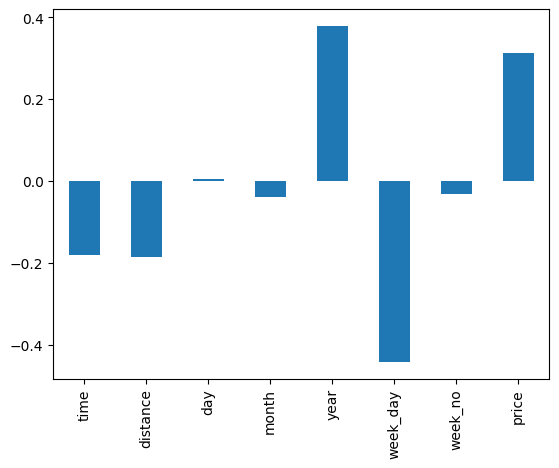

In [24]:
numeric_df = flight_filtered_df.select_dtypes(include=['number'])
flight_filtered_df[numeric_df.columns].skew().plot(kind='bar')

The variables with skewness > 1 price are highly positively skewed.

The variables with skewness < -1 are highly negatively skewed.

The variables with 0.5 < skewness < 1 are moderately positively skewed.

The variables with -0.5 < skewness < -1 are moderately negatively skewed.

The variables with -0.5 < skewness < 0.5 are symmetric i.e normally distributed

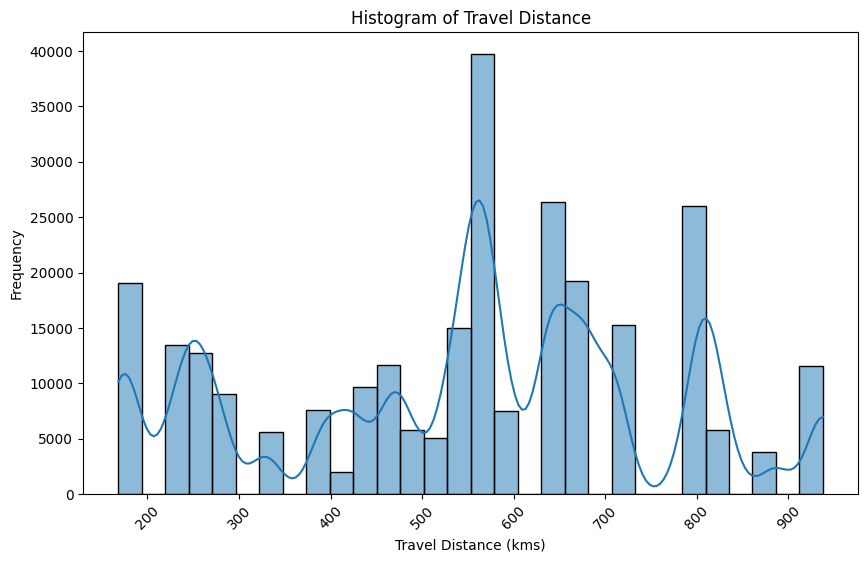

In [25]:
plt.figure(figsize=(10, 6))
sns.histplot(flight_filtered_df['distance'], bins=30, kde=True)
plt.title('Histogram of Travel Distance')
plt.xlabel('Travel Distance (kms)')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

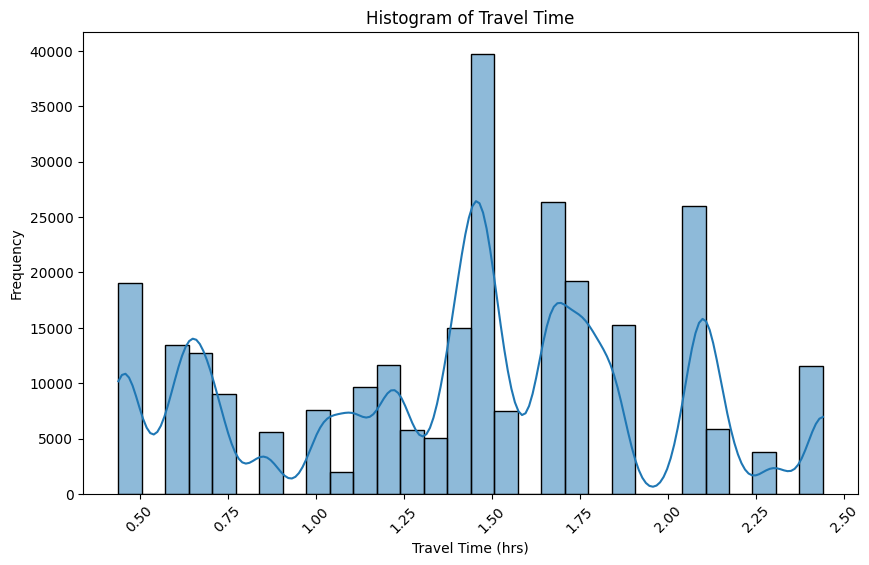

In [26]:
plt.figure(figsize=(10, 6))
sns.histplot(flight_filtered_df['time'], bins=30, kde=True)
plt.title('Histogram of Travel Time')
plt.xlabel('Travel Time (hrs)')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

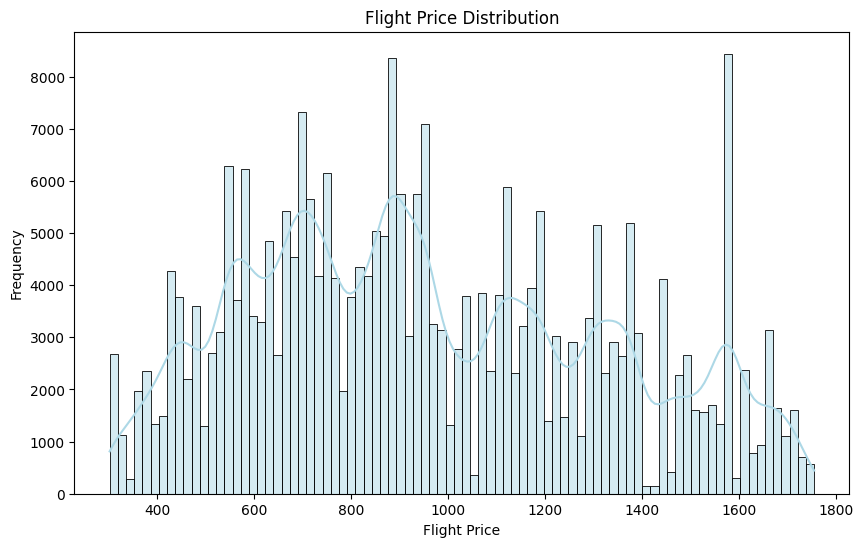

In [27]:
# Flight Price Distribution

plt.figure(figsize=(10, 6))
sns.histplot(flight_filtered_df['price'], kde=True, color='lightblue')
plt.title('Flight Price Distribution')
plt.xlabel('Flight Price')
plt.ylabel('Frequency')
plt.show()

Inference from the plot:


1.  The majority of the prices seem to be concentrated in a relatively narrow range, indicating a common price range for these travel packages.
2.   There is a long tail on the right side of the distribution, suggesting that there are a few travel packages with significantly higher prices compared to the majority.
3.   The distribution appears to be right-skewed, with prices tapering off as they increase.

Overall, this plot provides insight into the distribution of prices, which is valuable information for understanding the pricing structure of the travel packages in the dataset.

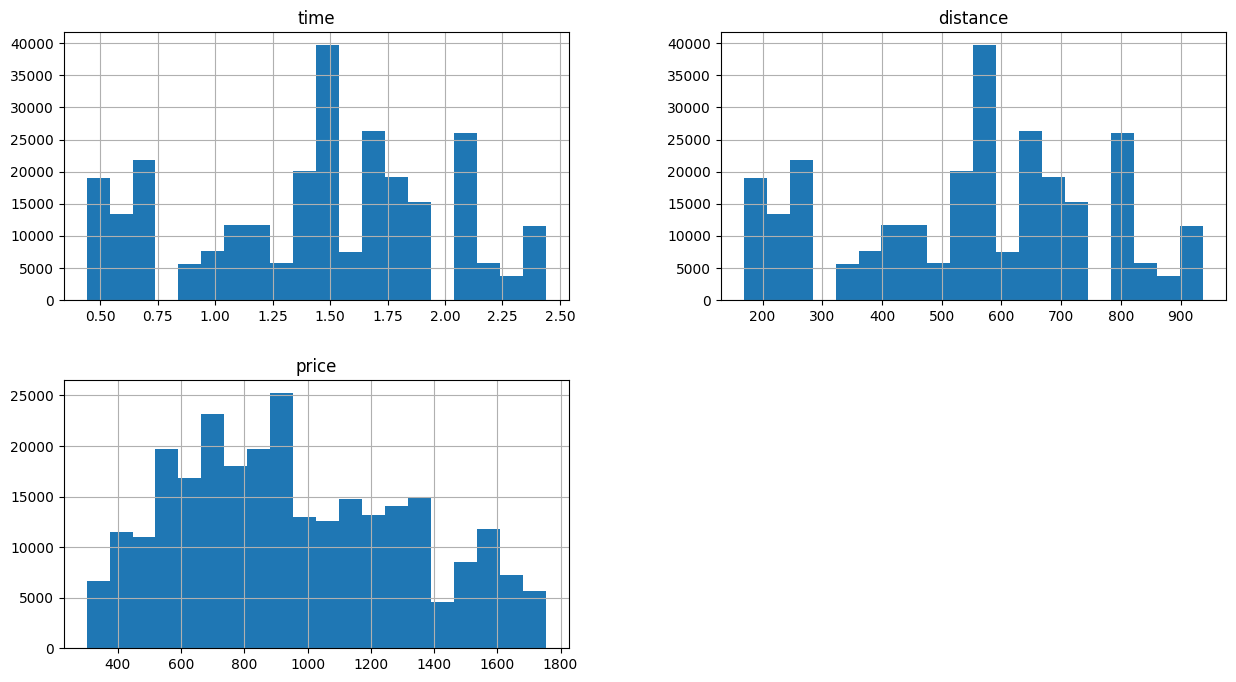

In [28]:
# Plot histograms for numeric columns
numeric_cols = flight_filtered_df.select_dtypes(include=['int64', 'float64']).columns
flight_filtered_df[numeric_cols].hist(bins=20, figsize=(15, 8))
plt.show()

**Checking for Outliers in Numerical Coulmns using Box-plot**

If the distribution of numerical column follows normal distribution, then use std to handle outliers.Otherwise we will use IQR technique.

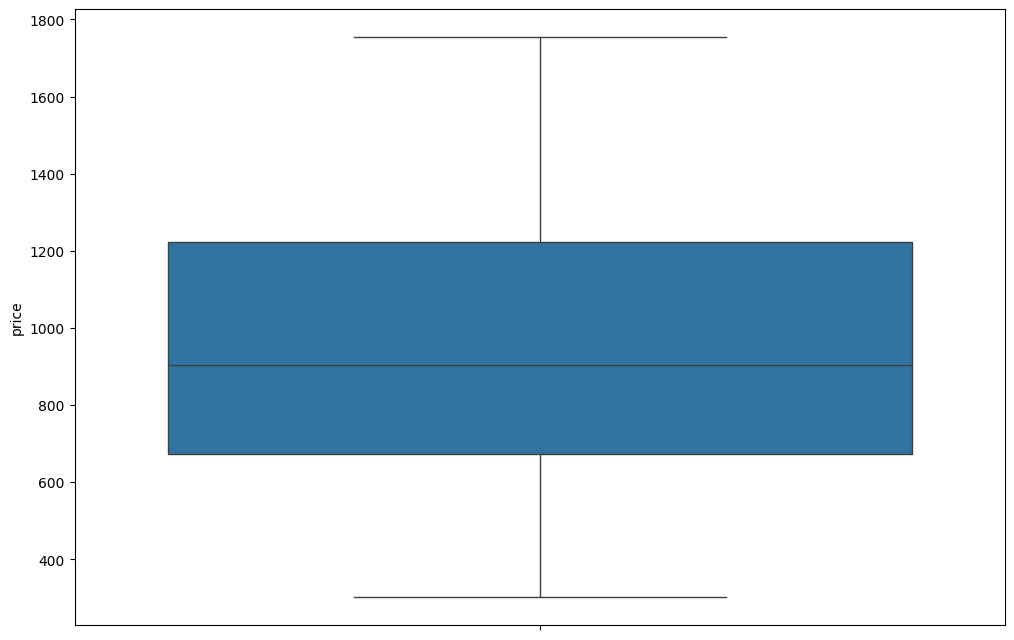

In [29]:
# Plot box plots for numeric columns to detect outliers
plt.figure(figsize=(12, 8))
sns.boxplot(data=flight_filtered_df['price'])
plt.xticks(rotation=45)
plt.show()

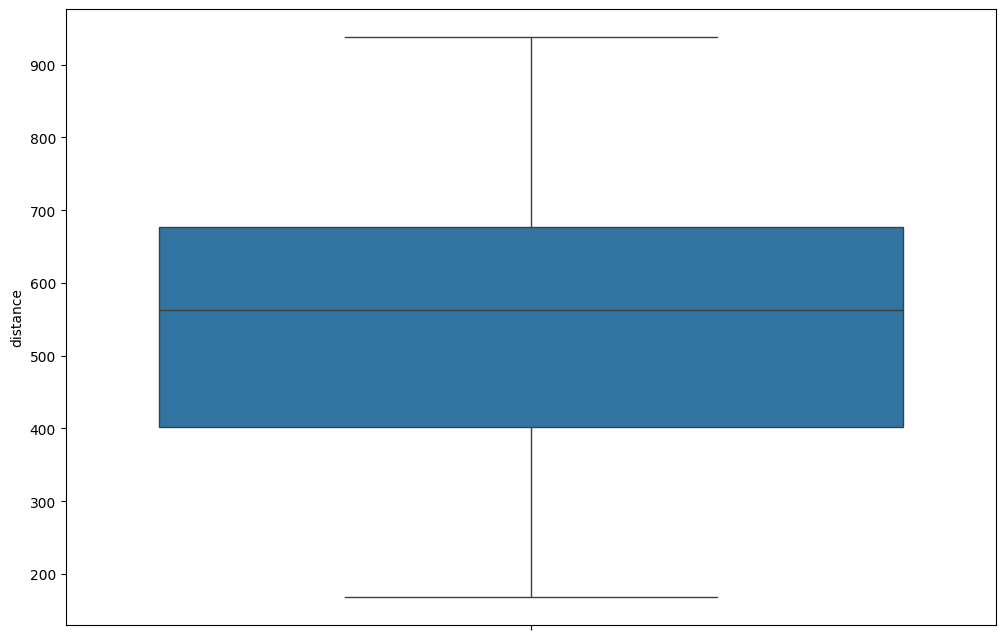

In [30]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=flight_filtered_df['distance'])
plt.xticks(rotation=45)
plt.show()

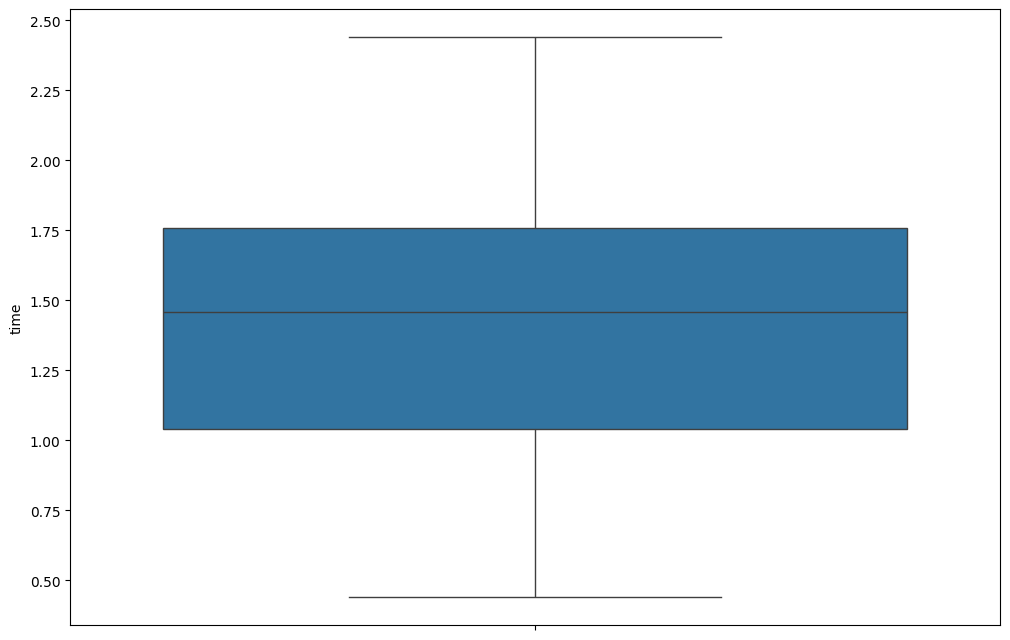

In [31]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=flight_filtered_df['time'])
plt.xticks(rotation=45)
plt.show()

**Distribution of Categories in Categorical Coulmns using a pie-chart**

flightType
firstClass    116418
premium        78004
economic       77466
Name: count, dtype: int64


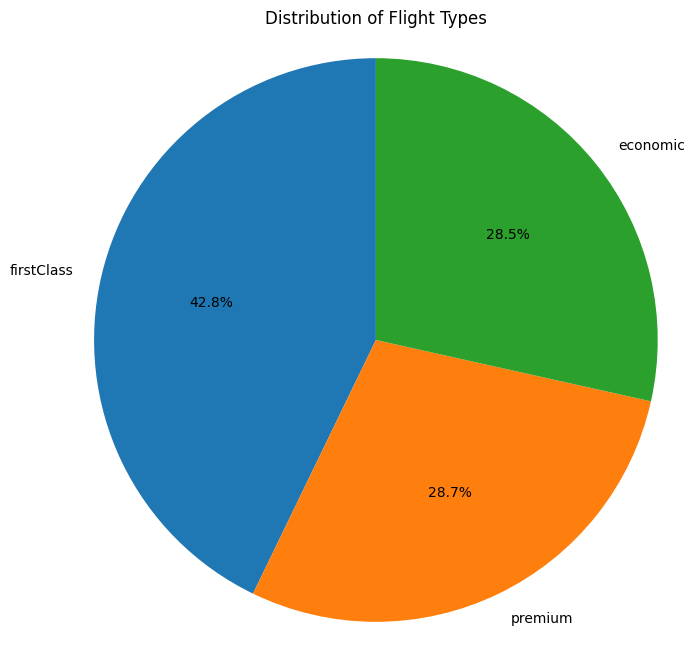

In [32]:
# Get the counts of each flight type
flight_type_counts = flight_filtered_df['flightType'].value_counts()

# Display the counts of each class in 'Flight Type'
print(flight_type_counts)

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(flight_type_counts, labels=flight_type_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Flight Types')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

agency
Rainbow        116752
CloudFy        116378
FlyingDrops     38758
Name: count, dtype: int64


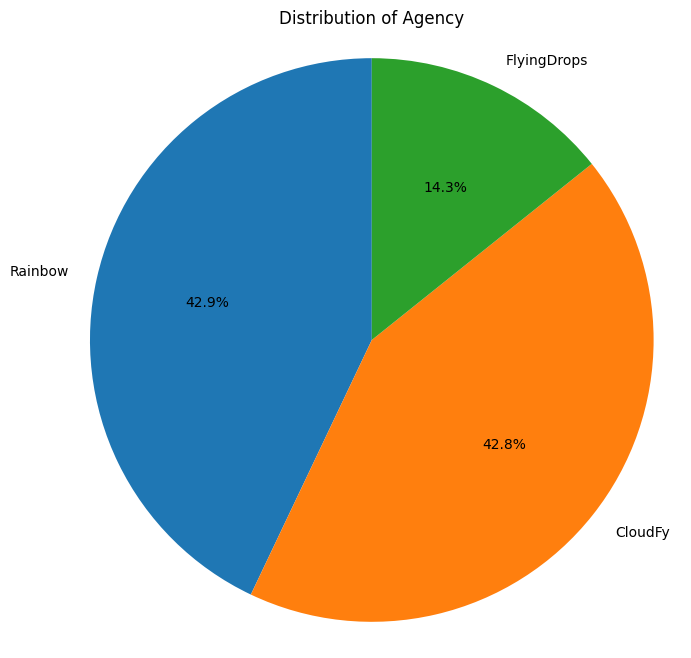

In [33]:
# Get the counts of each agency
agency_type_counts = flight_filtered_df['agency'].value_counts()

# Display the counts of each class in 'Agency Type'
print(agency_type_counts)

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(agency_type_counts, labels=agency_type_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Agency')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

Inference from the plot:

The pie chart illustrates the distribution of selected package types in the dataset. The data is categorized into five package types: Deluxe, Standard, Premium, Luxury, and Budget.

Deluxe and Standard are the most common package types, each making up a significant portion of the dataset. Premium is also fairly common, but slightly less frequent than Deluxe and Standard. Luxury packages are less common but still represent a substantial portion of the dataset. Budget packages are the least common among the selected types, comprising a relatively small percentage of the dataset.

agency
Rainbow        116752
CloudFy        116378
FlyingDrops     38758
Name: count, dtype: int64


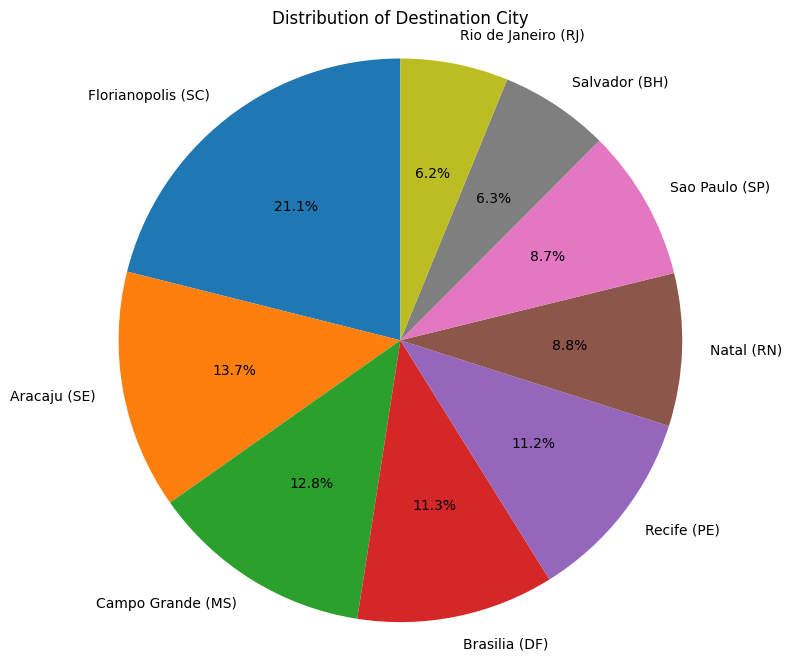

In [34]:
# Get the counts of each destination_city_counts
destination_city_counts = flight_filtered_df['to'].value_counts()

# Display the counts of each class in 'Destination Cities'
print(agency_type_counts)

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(destination_city_counts, labels=destination_city_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Destination City')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

**Distribution of Values in Numerical Coulmns using a pie-chart**

week_day
3    135944
0     34108
6     34088
4     33880
5     33868
Name: count, dtype: int64


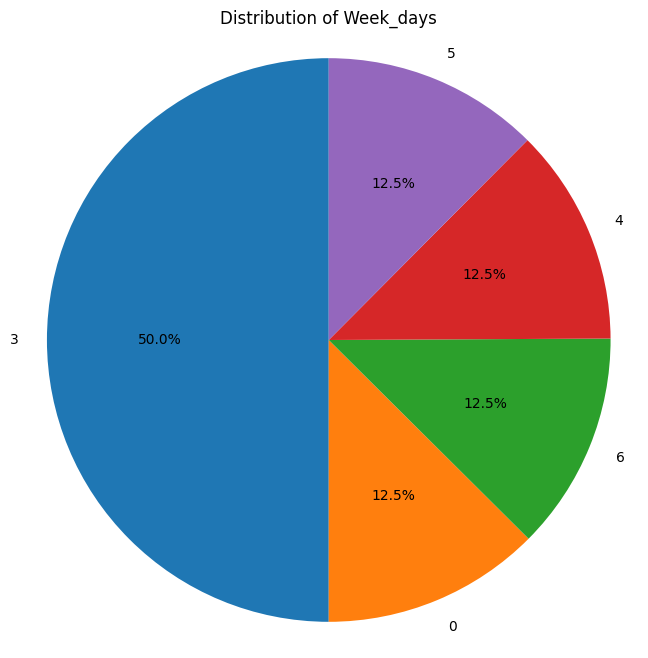

In [35]:
# Get the counts of each flight type
week_day_type_counts = flight_filtered_df['week_day'].value_counts()

# Display the counts of each class in 'Week days'
print(week_day_type_counts)

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(week_day_type_counts, labels=week_day_type_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Week_days')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

<Axes: xlabel='week_day', ylabel='count'>

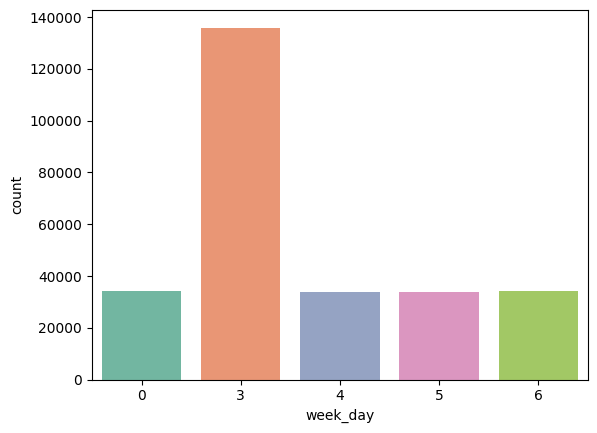

In [36]:
sns.countplot(x='week_day',data=flight_filtered_df,palette = "Set2")

year
2020    112571
2021     75363
2022     41761
2019     35826
2023      6367
Name: count, dtype: int64


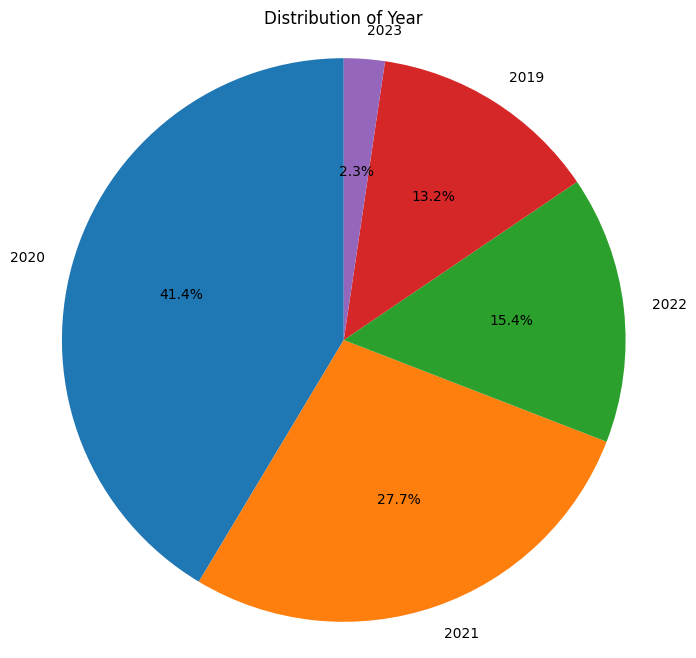

In [37]:
# Get the counts of each flight type
year_counts = flight_filtered_df['year'].value_counts()

# Display the counts of each class in 'Week days'
print(year_counts)

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(year_counts, labels=year_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Year')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

<Axes: xlabel='year', ylabel='count'>

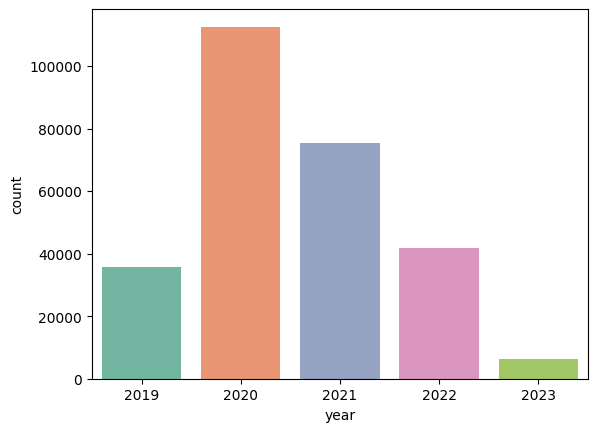

In [38]:
sns.countplot(x='year',data=flight_filtered_df,palette = "Set2")

**Bivariate Analysis**

Check for Linear relationship btwn Independent numerical Variable and Target variable

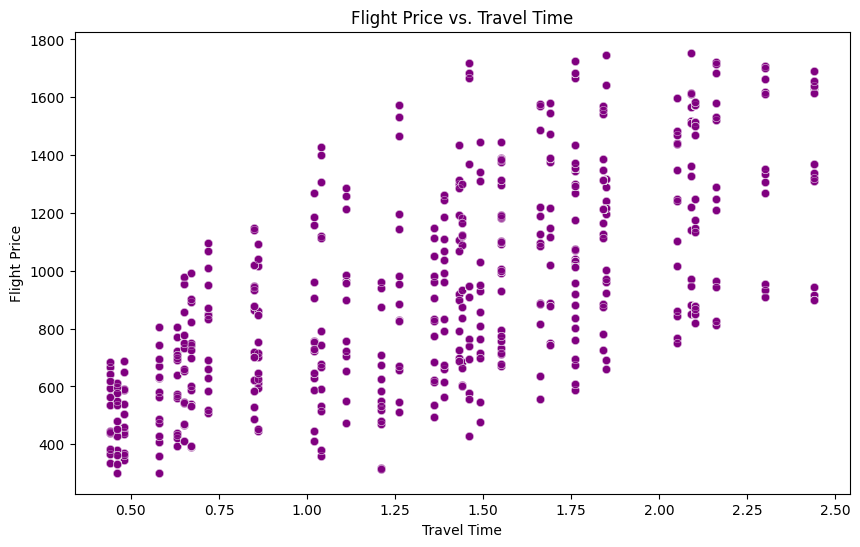

In [39]:
# Price vs. Travel Time

plt.figure(figsize=(10, 6))
sns.scatterplot(data=flight_filtered_df, x='time', y='price', color='purple', alpha=0.5)
plt.title('Flight Price vs. Travel Time')
plt.xlabel('Travel Time')
plt.ylabel('Flight Price')
plt.show()

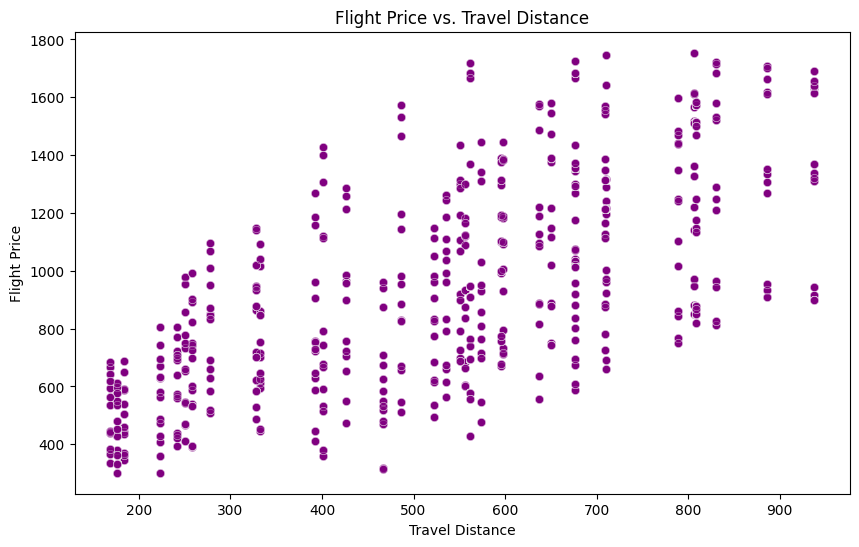

In [40]:
# Price vs. Travel Distance

plt.figure(figsize=(10, 6))
sns.scatterplot(data=flight_filtered_df, x='distance', y='price', color='purple', alpha=0.5)
plt.title('Flight Price vs. Travel Distance')
plt.xlabel('Travel Distance')
plt.ylabel('Flight Price')
plt.show()

Check for Outliers in Categorical Coulmns

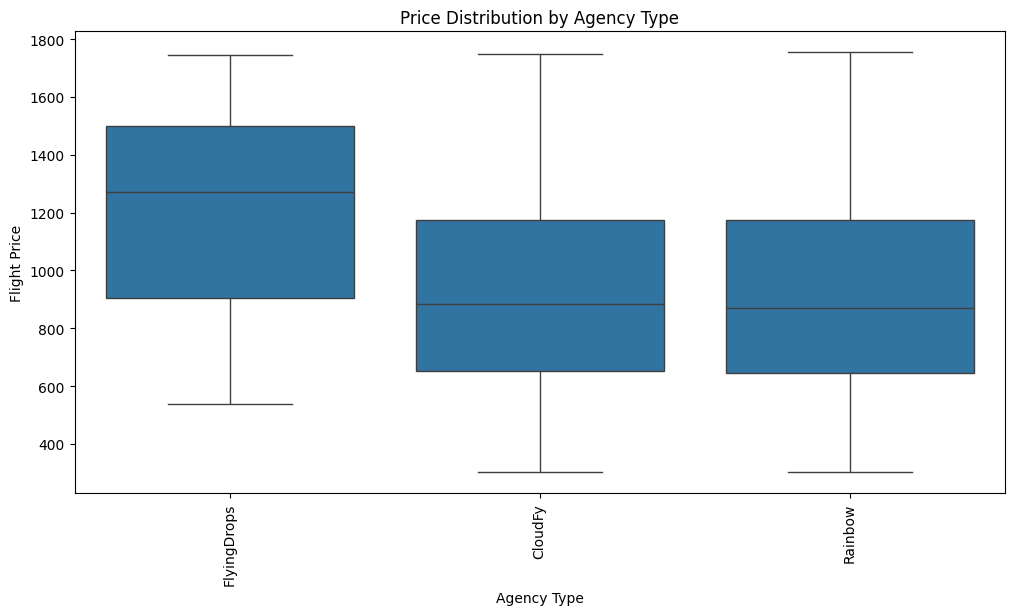

In [41]:
# Box Plots:
# Visualize the distribution of prices per agency type:

plt.figure(figsize=(12, 6))
sns.boxplot(data=flight_filtered_df, x='agency', y='price')
plt.xticks(rotation=90)
plt.xlabel('Agency Type')
plt.ylabel('Flight Price')
plt.title('Price Distribution by Agency Type')
plt.show()

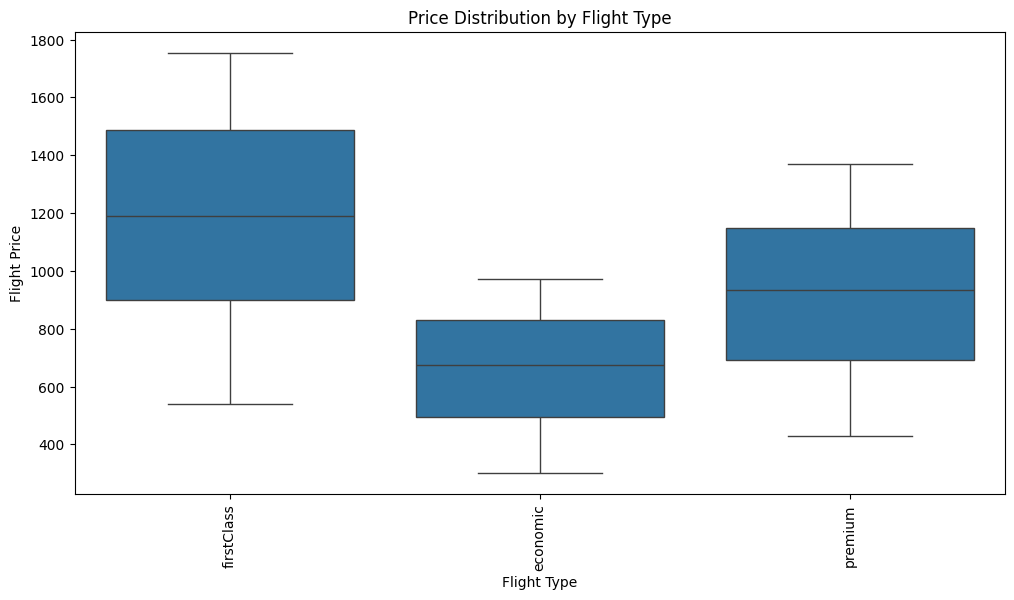

In [42]:
# Box Plots:
# Visualize the distribution of prices per Flight type:

plt.figure(figsize=(12, 6))
sns.boxplot(data=flight_filtered_df, x='flightType', y='price')
plt.xticks(rotation=90)
plt.xlabel('Flight Type')
plt.ylabel('Flight Price')
plt.title('Price Distribution by Flight Type')
plt.show()

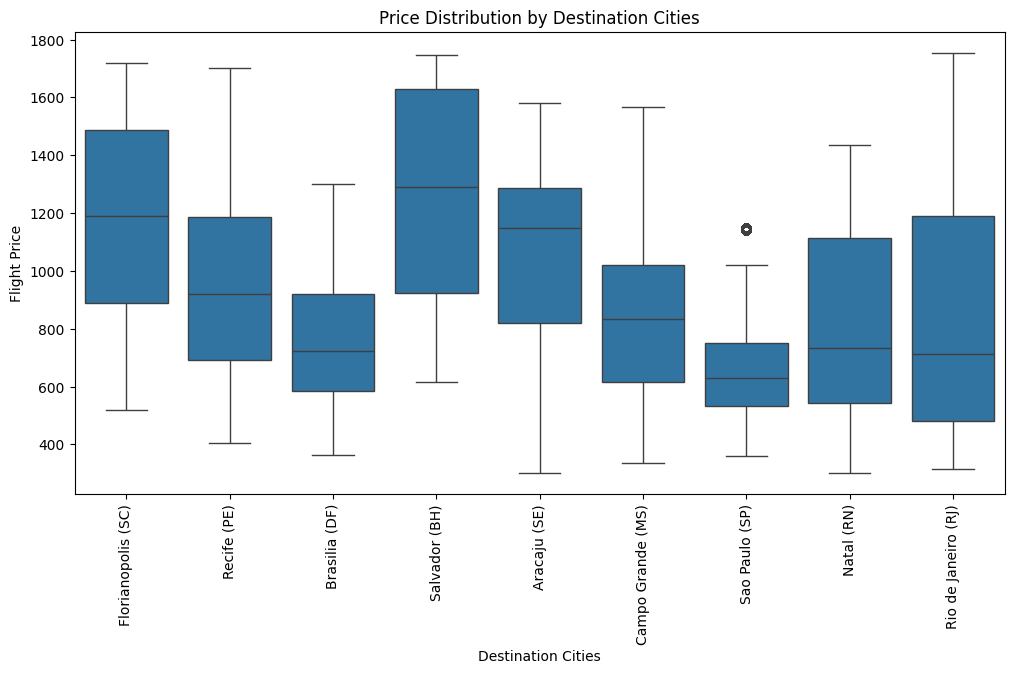

In [43]:
# Box Plots:
# Visualize the distribution of prices per Destination Cities:

plt.figure(figsize=(12, 6))
sns.boxplot(data=flight_filtered_df, x='to', y='price')
plt.xticks(rotation=90)
plt.xlabel('Destination Cities')
plt.ylabel('Flight Price')
plt.title('Price Distribution by Destination Cities')
plt.show()

Inference of the plot:

1. Variability: The box plots reveal varying levels of price variability within different package types. Some package types have a wider range of prices (larger boxes), while others have narrower ranges (smaller boxes).

2. Outliers: Outliers, represented as individual points beyond the "whiskers" of the boxes, can be seen in several package types. These outliers indicate some extreme price values within those categories.

3. Median Prices: The horizontal line inside each box represents the median price for each package type. It's a quick way to compare the typical prices across different categories.

4. Package Type Impact: The plot provides a visual sense of how package type influences price distribution. Some package types consistently have higher or lower prices than others.

Visualize the distribution of prices per Categorical Coulmns using bar-plot

<Axes: xlabel='flightType', ylabel='price'>

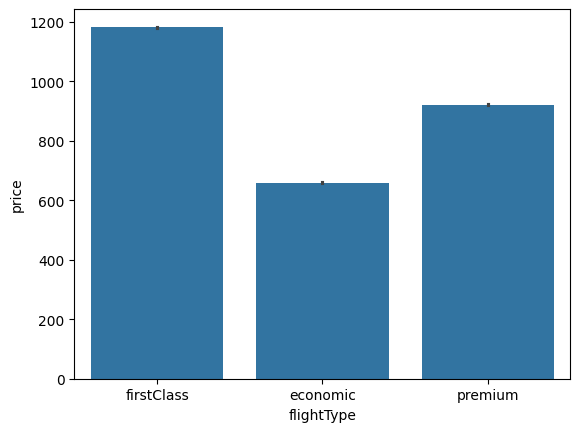

In [44]:
sns.barplot(x='flightType',y='price', data=flight_filtered_df)

sns.barplot(x='flightType',y='price', data=flight_filtered_df)

<Axes: xlabel='agency', ylabel='price'>

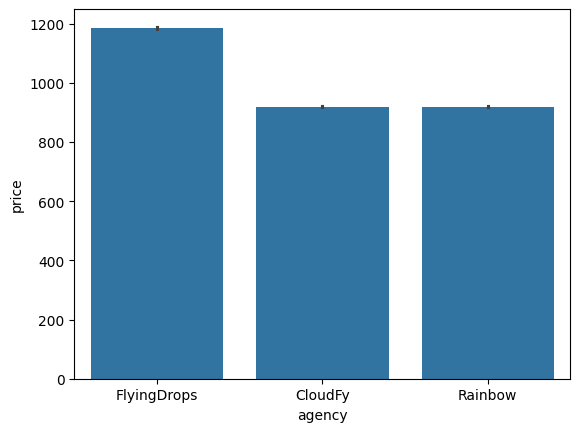

In [45]:
sns.barplot(x='agency',y='price', data=flight_filtered_df)

**Feature Engineering**

In [46]:
# renaming the Column name
flight_filtered_df.rename(columns={"to":"destination"},inplace=True)

In [47]:
# Creating a new feature using distance and time columns
flight_filtered_df['flight_speed']=round(flight_filtered_df['distance']/flight_filtered_df['time'],2)

In [48]:
flight_filtered_df.head()

,from,destination,flightType,agency,time,distance,day,month,year,week_day,week_no,price,flight_speed
0,Recife (PE),Florianopolis (SC),firstClass,FlyingDrops,1.76,676.53,26,9,2019,3,39,1434.38,384.39
1,Florianopolis (SC),Recife (PE),firstClass,FlyingDrops,1.76,676.53,30,9,2019,0,40,1292.29,384.39
2,Brasilia (DF),Florianopolis (SC),firstClass,CloudFy,1.66,637.56,3,10,2019,3,40,1487.52,384.07
3,Florianopolis (SC),Brasilia (DF),firstClass,CloudFy,1.66,637.56,4,10,2019,4,40,1127.36,384.07
4,Aracaju (SE),Salvador (BH),firstClass,CloudFy,2.16,830.86,10,10,2019,3,41,1684.05,384.66


<Axes: xlabel='flight_speed'>

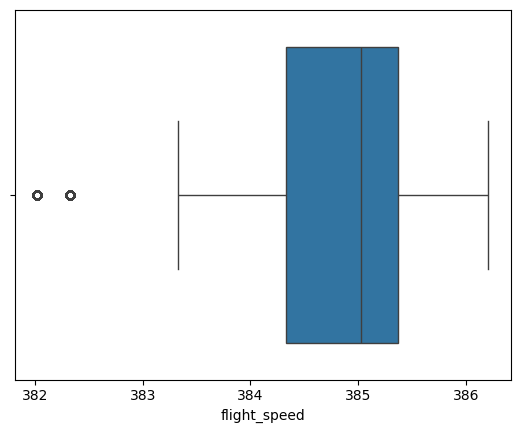

In [49]:
sns.boxplot(x=flight_filtered_df['flight_speed'])

In [50]:
Q1= np.percentile(flight_filtered_df['flight_speed'],25)
Q3= np.percentile(flight_filtered_df['flight_speed'],75)
IQR= Q3-Q1

In [51]:
lower_bound= Q1- IQR*1.5
upper_bound= Q3+IQR*1.5

The distribution of flight speed coulmn in the above graph is indicating a left skew due to outliers ,these outliers we can see in box plot occuring below the flight speed of 383km/hr. It may be not considered as outlier in this case,because these are valid data poits and these speed occured due to bad weather condition most probably.

In [52]:
# Calculate skewness only for numeric columns
flight_filtered_df.select_dtypes(include='number').skew()

,0
time,-0.179825
distance,-0.183944
day,0.006463
month,-0.039119
year,0.378661
week_day,-0.441701
week_no,-0.030191
price,0.313578
flight_speed,-1.037095


In [53]:
df=flight_filtered_df.copy()
df.describe()

,time,distance,day,month,year,week_day,week_no,price,flight_speed
count,271888.000000,271888.000000,271888.000000,271888.000000,271888.000000,271888.000000,271888.0,271888.00000,271888.000000
mean,1.421147,546.955535,15.790458,6.607519,2020.522862,3.373521,27.04532,957.37503,384.785156
std,0.542541,208.851288,8.826961,3.606611,0.980161,1.655530,15.793449,362.31189,0.850795
min,0.440000,168.220000,1.000000,1.000000,2019.000000,0.000000,1.0,301.51000,382.020000
25%,1.040000,401.660000,8.000000,3.000000,2020.000000,3.000000,13.0,672.66000,384.330000
50%,1.460000,562.140000,16.000000,7.000000,2020.000000,3.000000,27.0,904.00000,385.030000
75%,1.760000,676.530000,24.000000,10.000000,2021.000000,4.000000,42.0,1222.24000,385.370000
max,2.440000,937.770000,31.000000,12.000000,2023.000000,6.000000,53.0,1754.17000,386.210000


In [54]:
flight_filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271888 entries, 0 to 271887
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   from          271888 non-null  object 
 1   destination   271888 non-null  object 
 2   flightType    271888 non-null  object 
 3   agency        271888 non-null  object 
 4   time          271888 non-null  float64
 5   distance      271888 non-null  float64
 6   day           271888 non-null  int32  
 7   month         271888 non-null  int32  
 8   year          271888 non-null  int32  
 9   week_day      271888 non-null  int32  
 10  week_no       271888 non-null  UInt32 
 11  price         271888 non-null  float64
 12  flight_speed  271888 non-null  float64
dtypes: UInt32(1), float64(4), int32(4), object(4)
memory usage: 22.0+ MB


One-hot encoding

In [55]:
# Example of one-hot encoding
flight_filtered_df = pd.get_dummies(flight_filtered_df, columns=['from','destination','flightType','agency'])

In [56]:
flight_filtered_df.shape

(271888, 33)

**Feature Selection**

Feature Selection Using Statistical Test ANNOVA F-Test

In [57]:
final_df1= flight_filtered_df.drop(columns=['time','flight_speed','month','year','distance'],axis=1)

In [58]:
import pandas as pd
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif

# Assuming df is your DataFrame with features and target variable 'target'

# Separate features (X) and target variable (y)
X = final_df1.drop('price', axis=1)  # Features
y = final_df1['price']                # Target variable

# Select top k features based on chi-squared test for categorical features
num_features = X.select_dtypes(include=['number']).columns

# ANOVA F-test for numerical features
f_selector = SelectKBest(score_func=f_classif, k=3)
f_selector.fit(X[num_features], y)

# Get indices of top k features for both categorical and numerical features

numerical_top_indices = f_selector.get_support(indices=True)

# Combine top indices
top_indices = list(numerical_top_indices)

# Get top k feature names
top_features = X.columns[top_indices]

# Display top k features
print("Top k selected features:")
print(top_features)

Top k selected features:
Index(['day', 'week_day', 'week_no'], dtype='object')


In [59]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor # Import the missing function

def calc_vif(X):
    # Convert categorical columns to numerical using one-hot encoding
    X_encoded = pd.get_dummies(X, drop_first=True)  # Drop first category to avoid multicollinearity

    # Select only numerical columns after one-hot encoding
    X_encoded_numeric = X_encoded.select_dtypes(include=['number'])

    # Calculate VIF for each numerical column
    vif = pd.DataFrame()
    vif['features'] = X_encoded_numeric.columns
    vif['vif_value'] = [variance_inflation_factor(X_encoded_numeric.values, i) for i in range(X_encoded_numeric.shape[1])]

    return vif[['features', 'vif_value']]
    # Example usage
df = pd.DataFrame({
    'categorical_feature_1': ['A', 'B', 'C', 'A', 'B'],
    'categorical_feature_2': ['X', 'Y', 'Z', 'X', 'Y'],
    'numerical_feature_1': [1, 2, 3, 4, 5],
    'numerical_feature_2': [6, 7, 8, 9, 10]
})

vif_df = calc_vif(df)
print(vif_df)

              features  vif_value
0  numerical_feature_1      14.52
1  numerical_feature_2      14.52


In [60]:
X.rename(columns={'from_Sao Paulo (SP)':'from_Sao_Paulo (SP)','from_Rio de Janeiro (RJ)':'from_Rio_de_Janeiro (RJ)','from_Campo Grande (MS)':'from_Campo_Grande (MS)',
                                  'destination_Sao Paulo (SP)':'destination_Sao_Paulo (SP)','destination_Rio de Janeiro (RJ)':'destination_Rio_de_Janeiro (RJ)','destination_Campo Grande (MS)':'destination_Campo_Grande (MS)'},inplace=True)

In [61]:
features_ordering=['from_Florianopolis (SC)',
 'from_Sao_Paulo (SP)',
 'from_Salvador (BH)',
 'from_Brasilia (DF)',
 'from_Rio_de_Janeiro (RJ)',
 'from_Campo_Grande (MS)',
 'from_Aracaju (SE)',
 'from_Natal (RN)',
 'from_Recife (PE)',
 'destination_Florianopolis (SC)',
 'destination_Sao_Paulo (SP)',
 'destination_Salvador (BH)',
 'destination_Brasilia (DF)',
 'destination_Rio_de_Janeiro (RJ)',
 'destination_Campo_Grande (MS)',
 'destination_Aracaju (SE)',
 'destination_Natal (RN)',
 'destination_Recife (PE)',
 'flightType_economic',
 'flightType_firstClass',
 'flightType_premium',
 'agency_Rainbow',
 'agency_CloudFy',
 'agency_FlyingDrops',
 'week_no',
 'week_day',
 'day']

In [62]:
#Ordering features based on flask output
final_features_1= X[features_ordering]

In [63]:
X1= final_features_1

# Target variable
y1 = y

# Split the data into training and testing sets
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=42)

scaler_new = StandardScaler()

X_train1 = scaler_new.fit_transform(X_train1)
X_test1 = scaler_new.transform(X_test1)

In [64]:
final_features_1.columns

Index(['from_Florianopolis (SC)', 'from_Sao_Paulo (SP)', 'from_Salvador (BH)',
       'from_Brasilia (DF)', 'from_Rio_de_Janeiro (RJ)',
       'from_Campo_Grande (MS)', 'from_Aracaju (SE)', 'from_Natal (RN)',
       'from_Recife (PE)', 'destination_Florianopolis (SC)',
       'destination_Sao_Paulo (SP)', 'destination_Salvador (BH)',
       'destination_Brasilia (DF)', 'destination_Rio_de_Janeiro (RJ)',
       'destination_Campo_Grande (MS)', 'destination_Aracaju (SE)',
       'destination_Natal (RN)', 'destination_Recife (PE)',
       'flightType_economic', 'flightType_firstClass', 'flightType_premium',
       'agency_Rainbow', 'agency_CloudFy', 'agency_FlyingDrops', 'week_no',
       'week_day', 'day'],
      dtype='object')

**Model Building, Training, Cross-Validation, Hyperparameter Tuning & Evaluation**

**Linear Regression**

**Baseline Model**

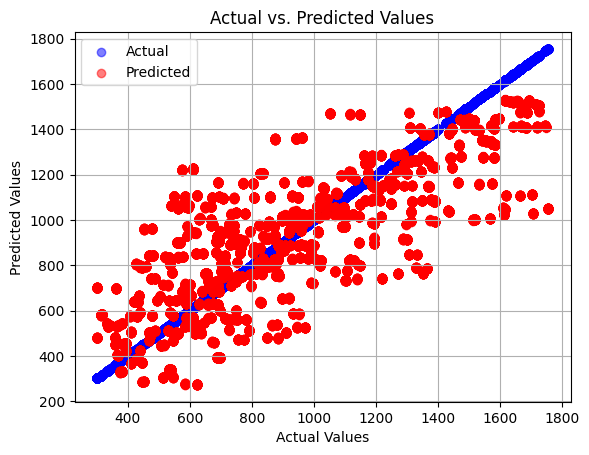

In [65]:
# Create and train the Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train1, y_train1)

# Make predictions on the test set
y_pred1 = linear_model.predict(X_test1)

# Evaluate the model
mae_lr = mean_absolute_error(y_test1, y_pred1)
mse_lr = mean_squared_error(y_test1, y_pred1)
rmse_lr = np.sqrt(mse_lr)
r2_lr = r2_score(y_test1, y_pred1)

# Calculate adjusted R-squared for linear regression
n = X_test1.shape[0]
p = X_test1.shape[1]
# Calculate adjusted R-squared
adj_r2_lr = 1 - ((1 - r2_lr) * (n - 1) / (n - p - 1))


plt.scatter(y_test1, y_test1, c='b', label='Actual', alpha=0.5)  # Blue for actual
plt.scatter(y_test1, y_pred1, c='r', label='Predicted', alpha=0.5)  # Red for predicted
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

**Model Evaluation**

In [66]:
model_result = pd.DataFrame([['Linear Regression Baseline', mse_lr,rmse_lr,mae_lr, r2_lr,adj_r2_lr]],
               columns = ['Model', 'MSE', 'RMSE', 'MAE', 'R2','adj_r2'])

model_result

,Model,MSE,RMSE,MAE,R2,adj_r2
0,Linear Regression Baseline,47023.0807,216.848059,165.358445,0.643141,0.642963


**Hyperparameter Tuning Linear**

In [67]:
# Define hyperparameters and their potential values
param_grid_linear = {
    'fit_intercept': [True, False],
    'positive': [True, False]
}

# Create a GridSearchCV object for Linear Regression
grid_lr = GridSearchCV(linear_model, param_grid_linear, cv=3, scoring='neg_mean_squared_error')
grid_lr.fit(X_train1, y_train1)

# Get the best hyperparameters for Linear Regression
best_linear_reg = grid_lr.best_estimator_

# Perform grid search
best_linear_reg.fit(X_train1, y_train1)

LinearRegression()

In [68]:
# Print the best hyperparameters
print("Best Hyperparameters for Linear Regression:", grid_lr.best_estimator_)

Best Hyperparameters for Linear Regression: LinearRegression()


**Model Evaluation**

In [69]:
# Evaluate the model
y_pred_linear_tuned = best_linear_reg.predict(X_test1)

mae_linear_tuned = mean_absolute_error(y_test1, y_pred_linear_tuned )
mse_linear_tuned = mean_squared_error(y_test1, y_pred_linear_tuned )
rmse_linear_tuned = np.sqrt(mse_linear_tuned)
r2_linear_tuned = r2_score(y_test1, y_pred_linear_tuned )
adj_r2_linear_tuned = 1 - ((1 - r2_linear_tuned) * (n - 1) / (n - p - 1))

model = pd.DataFrame([['Linear Regression Tuned',  mse_linear_tuned,rmse_linear_tuned,mae_linear_tuned, r2_linear_tuned,adj_r2_linear_tuned]],
               columns = ['Model', 'MSE', 'RMSE', 'MAE', 'R2','adj_r2'])

model_result = pd.concat([model_result,model],axis=0,ignore_index = True)
model_result

,Model,MSE,RMSE,MAE,R2,adj_r2
0,Linear Regression Baseline,47023.0807,216.848059,165.358445,0.643141,0.642963
1,Linear Regression Tuned,47023.0807,216.848059,165.358445,0.643141,0.642963


**Lasso Regression**

**Baseline Model**

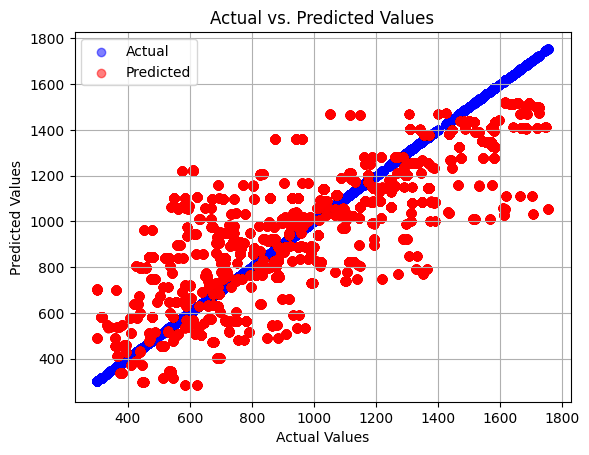

In [70]:
from sklearn.linear_model import Lasso


# Basic Lasso Regression
lasso_model = Lasso()  # You can adjust the alpha parameter for regularization strength
lasso_model.fit(X_train1, y_train1)

# Evaluate the model
y_pred_lasso = lasso_model.predict(X_test1)

mae_lasso = mean_absolute_error(y_test1, y_pred_lasso)
mse_lasso = mean_squared_error(y_test1, y_pred_lasso)
rmse_lasso = np.sqrt(mse_lasso)
r2_lasso = r2_score(y_test1, y_pred_lasso)
adj_r2_lasso = 1 - ((1 - r2_lasso) * (n - 1) / (n - p - 1))

plt.scatter(y_test1, y_test1, c='b', label='Actual', alpha=0.5)  # Blue for actual
plt.scatter(y_test1, y_pred_lasso, c='r', label='Predicted', alpha=0.5)  # Red for predicted
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

**Model Evaluation**

In [71]:
model = pd.DataFrame([['Lasso Regression Baseline',  mse_lasso,rmse_lasso,mae_lasso, r2_lasso,adj_r2_lasso]],
               columns = ['Model', 'MSE', 'RMSE', 'MAE', 'R2','adj_r2'])

model_result = pd.concat([model_result,model],axis=0,ignore_index = True)
model_result

,Model,MSE,RMSE,MAE,R2,adj_r2
0,Linear Regression Baseline,47023.080700,216.848059,165.358445,0.643141,0.642963
1,Linear Regression Tuned,47023.080700,216.848059,165.358445,0.643141,0.642963
2,Lasso Regression Baseline,47029.902715,216.863788,165.627117,0.643089,0.642912


**Hyperparameter Tuning Lasso**

In [72]:
# Hyperparameter tuning using GridSearchCV
from sklearn.model_selection import GridSearchCV

# Define hyperparameters and their potential values
param_grid = {
    'alpha': [0.001,0.01, 0.1,0.3,0.5,0.6,0.8, 1.0,10]  # Adjust the range of alpha values as needed
}

# Create a GridSearchCV object for Lasso Regression
grid_search_lasso = GridSearchCV(lasso_model, param_grid, cv=3, scoring='neg_mean_squared_error')

# Perform grid search
grid_search_lasso.fit(X_train1, y_train1)

# Get the best hyperparameters for Lasso Regression
best_lasso_model = grid_search_lasso.best_estimator_

# Fit the best model to the training data
best_lasso_model.fit(X_train1, y_train1)

Lasso(alpha=0.01)

In [73]:
# Print the best hyperparameters
print("Best Hyperparameters for Lasso Regression:", grid_search_lasso.best_params_)

Best Hyperparameters for Lasso Regression: {'alpha': 0.01}


**Model Evaluation**

In [74]:
# Evaluate the model
y_pred_lasso_tuned = best_lasso_model.predict(X_test1)

mae_lasso_tuned = mean_absolute_error(y_test1, y_pred_lasso_tuned )
mse_lasso_tuned = mean_squared_error(y_test1, y_pred_lasso_tuned )
rmse_lasso_tuned = np.sqrt(mse_lasso_tuned)
r2_lasso_tuned = r2_score(y_test1, y_pred_lasso_tuned )
adj_r2_lasso_tuned = 1 - ((1 - r2_lasso_tuned) * (n - 1) / (n - p - 1))

model = pd.DataFrame([['Lasso Regression Tuned',  mse_lasso_tuned,rmse_lasso_tuned,mae_lasso_tuned, r2_lasso_tuned,adj_r2_lasso_tuned]],
               columns = ['Model', 'MSE', 'RMSE', 'MAE', 'R2','adj_r2'])

model_result = pd.concat([model_result,model],axis=0,ignore_index = True)
model_result

,Model,MSE,RMSE,MAE,R2,adj_r2
0,Linear Regression Baseline,47023.080700,216.848059,165.358445,0.643141,0.642963
1,Linear Regression Tuned,47023.080700,216.848059,165.358445,0.643141,0.642963
2,Lasso Regression Baseline,47029.902715,216.863788,165.627117,0.643089,0.642912
3,Lasso Regression Tuned,47022.986109,216.847841,165.360732,0.643141,0.642964


**Ridge Regression**

**Baseline Model**

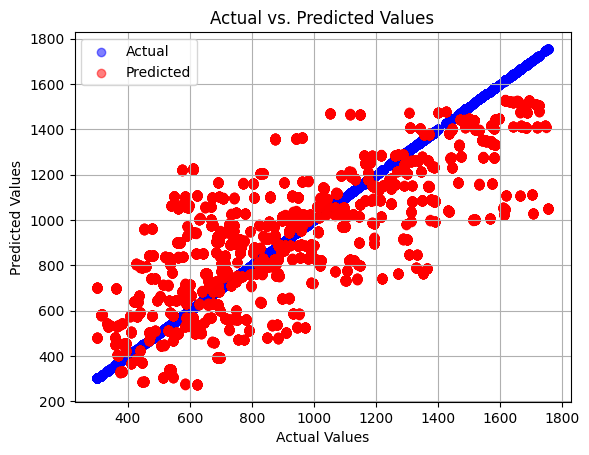

In [75]:
from sklearn.linear_model import Ridge

# Basic Ridge Regression
ridge_model = Ridge()  # You can adjust the alpha parameter for regularization strength
ridge_model.fit(X_train1, y_train1)

# Evaluate the model
y_pred_ridge = ridge_model.predict(X_test1)

mae_ridge = mean_absolute_error(y_test1, y_pred_ridge)
mse_ridge = mean_squared_error(y_test1,y_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)
r2_ridge = r2_score(y_test1, y_pred_ridge)
adj_r2_ridge = 1 - ((1 - r2_ridge) * (n - 1) / (n - p - 1))

plt.scatter(y_test1, y_test1, c='b', label='Actual', alpha=0.5)  # Blue for actual
plt.scatter(y_test1, y_pred_ridge, c='r', label='Predicted', alpha=0.5)  # Red for predicted
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

**Model Evaluation**

In [76]:
model = pd.DataFrame([['Ridge Regression Baseline',  mse_ridge,rmse_ridge,mae_ridge, r2_ridge,adj_r2_ridge]],
               columns = ['Model', 'MSE', 'RMSE', 'MAE', 'R2','adj_r2'])

model_result = pd.concat([model_result,model],axis=0,ignore_index = True)
model_result

,Model,MSE,RMSE,MAE,R2,adj_r2
0,Linear Regression Baseline,47023.080700,216.848059,165.358445,0.643141,0.642963
1,Linear Regression Tuned,47023.080700,216.848059,165.358445,0.643141,0.642963
2,Lasso Regression Baseline,47029.902715,216.863788,165.627117,0.643089,0.642912
3,Lasso Regression Tuned,47022.986109,216.847841,165.360732,0.643141,0.642964
4,Ridge Regression Baseline,47023.078125,216.848053,165.358494,0.643141,0.642963


**Hyperparameter Tuning Ridge**

In [77]:
# Hyperparameter tuning using GridSearchCV
param_grid = {
    'alpha': [0.001,0.01, 0.1,0.3,0.5,0.6,0.8, 1.0,10,20,50]  # Adjust the range of alpha values as needed
}


# Create a GridSearchCV object for Ridge Regression
grid_search_ridge = GridSearchCV(ridge_model, param_grid, cv=3, scoring='neg_mean_squared_error')

grid_search_ridge.fit(X_train1, y_train1)

# Get the best hyperparameters for Ridge Regression
best_ridge_model = grid_search_ridge.best_estimator_

# Perform grid search
best_ridge_model.fit(X_train1, y_train1)

Ridge(alpha=20)

In [78]:
# Print the best hyperparameters
print("Best Hyperparameters for Ridge Regression:", grid_search_ridge.best_estimator_
)

Best Hyperparameters for Ridge Regression: Ridge(alpha=20)


**Model Evaluation**

In [79]:
# Evaluate the model
y_pred_ridge_tuned = best_ridge_model.predict(X_test1)

mae_ridge_tuned = mean_absolute_error(y_test1, y_pred_ridge_tuned )
mse_ridge_tuned = mean_squared_error(y_test1, y_pred_ridge_tuned )
rmse_ridge_tuned = np.sqrt(mse_ridge_tuned)
r2_ridge_tuned = r2_score(y_test1, y_pred_ridge_tuned )
adj_r2_ridge_tuned = 1 - ((1 - r2_ridge_tuned) * (n - 1) / (n - p - 1))

model = pd.DataFrame([['Ridge Regression Tuned',  mse_ridge_tuned,rmse_ridge_tuned,mae_ridge_tuned, r2_ridge_tuned,adj_r2_ridge_tuned]],
               columns = ['Model', 'MSE', 'RMSE', 'MAE', 'R2','adj_r2'])

model_result = pd.concat([model_result,model],axis=0,ignore_index = True)
model_result

,Model,MSE,RMSE,MAE,R2,adj_r2
0,Linear Regression Baseline,47023.080700,216.848059,165.358445,0.643141,0.642963
1,Linear Regression Tuned,47023.080700,216.848059,165.358445,0.643141,0.642963
2,Lasso Regression Baseline,47029.902715,216.863788,165.627117,0.643089,0.642912
3,Lasso Regression Tuned,47022.986109,216.847841,165.360732,0.643141,0.642964
4,Ridge Regression Baseline,47023.078125,216.848053,165.358494,0.643141,0.642963
5,Ridge Regression Tuned,47023.029642,216.847941,165.359413,0.643141,0.642964


**ElasticNet**

**Baseline Model**

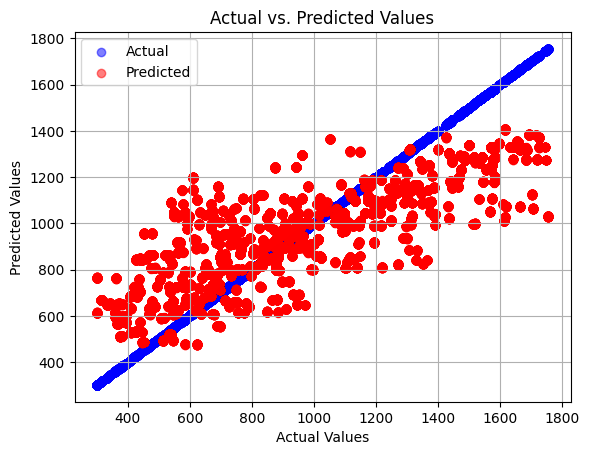

In [80]:
from sklearn.linear_model import ElasticNet

# Basic ElasticNet Regression
elasticnet_model = ElasticNet()  # You can adjust the alpha and l1_ratio parameters for regularization strength
elasticnet_model.fit(X_train1, y_train1)

# Evaluate the model
y_pred_elastic = elasticnet_model.predict(X_test1)


mae_elastic = mean_absolute_error(y_test1, y_pred_elastic)
mse_elastic = mean_squared_error(y_test1, y_pred_elastic)
rmse_elastic = np.sqrt(mse_elastic)
r2_elastic = r2_score(y_test1, y_pred_elastic)
adj_r2_elastic = 1 - ((1 - r2_elastic) * (n - 1) / (n - p - 1))

plt.scatter(y_test1, y_test1, c='b', label='Actual', alpha=0.5)  # Blue for actual
plt.scatter(y_test1, y_pred_elastic, c='r', label='Predicted', alpha=0.5)  # Red for predicted
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

**Model Evaluation**

In [81]:
model = pd.DataFrame([['ElasticNet Baseline',  mse_elastic,rmse_elastic,mae_elastic, r2_elastic,adj_r2_elastic]],
               columns = ['Model', 'MSE', 'RMSE', 'MAE', 'R2','adj_r2'])

model_result = pd.concat([model_result,model],axis=0,ignore_index = True)
model_result

,Model,MSE,RMSE,MAE,R2,adj_r2
0,Linear Regression Baseline,47023.080700,216.848059,165.358445,0.643141,0.642963
1,Linear Regression Tuned,47023.080700,216.848059,165.358445,0.643141,0.642963
2,Lasso Regression Baseline,47029.902715,216.863788,165.627117,0.643089,0.642912
3,Lasso Regression Tuned,47022.986109,216.847841,165.360732,0.643141,0.642964
4,Ridge Regression Baseline,47023.078125,216.848053,165.358494,0.643141,0.642963
5,Ridge Regression Tuned,47023.029642,216.847941,165.359413,0.643141,0.642964
6,ElasticNet Baseline,53547.622185,231.403592,184.529637,0.593626,0.593424


**Hyperparameter Tuning ElasticNet**

In [82]:
# Hyperparameter tuning using GridSearchCV
param_grid = {
    'fit_intercept': [True, False],
    'alpha': [0.1, 1.0, 10.0],
    'l1_ratio': [0.1, 0.5, 0.9],
    'max_iter': [100, 500, 1000],

}

# Create a GridSearchCV object for ElasticNet Regression
grid_search_elastic = GridSearchCV(elasticnet_model, param_grid, cv=3, scoring='neg_mean_squared_error')

# Perform grid search
grid_search_elastic.fit(X_train1, y_train1)

# Get the best hyperparameters for ElasticNet Regression
best_elasticnet_model = grid_search_elastic.best_estimator_

In [83]:
# Print the best hyperparameters
print("Best Hyperparameters for ElasticNet Regression:", grid_search_elastic.best_estimator_)

Best Hyperparameters for ElasticNet Regression: ElasticNet(alpha=0.1, l1_ratio=0.9, max_iter=100)


**Model Evaluation**

In [84]:
# Evaluate the best model
y_pred_elastic_tuned = best_elasticnet_model.predict(X_test1)

mae_elastic_tuned = mean_absolute_error(y_test1, y_pred_elastic_tuned)
mse_elastic_tuned = mean_squared_error(y_test1, y_pred_elastic_tuned)
rmse_elastic_tuned = np.sqrt(mse_elastic_tuned)
r2_elastic_tuned = r2_score(y_test1, y_pred_elastic_tuned)
adj_r2_elastic_tuned = 1 - ((1 - r2_elastic) * (n - 1) / (n - p - 1))

model = pd.DataFrame([['ElasticNet Tuned',  mse_elastic_tuned,rmse_elastic_tuned,mae_elastic_tuned, r2_elastic_tuned,adj_r2_elastic_tuned]],
               columns = ['Model', 'MSE', 'RMSE', 'MAE', 'R2','adj_r2'])

model_result = pd.concat([model_result,model],axis=0,ignore_index = True)
model_result

,Model,MSE,RMSE,MAE,R2,adj_r2
0,Linear Regression Baseline,47023.080700,216.848059,165.358445,0.643141,0.642963
1,Linear Regression Tuned,47023.080700,216.848059,165.358445,0.643141,0.642963
2,Lasso Regression Baseline,47029.902715,216.863788,165.627117,0.643089,0.642912
3,Lasso Regression Tuned,47022.986109,216.847841,165.360732,0.643141,0.642964
4,Ridge Regression Baseline,47023.078125,216.848053,165.358494,0.643141,0.642963
5,Ridge Regression Tuned,47023.029642,216.847941,165.359413,0.643141,0.642964
6,ElasticNet Baseline,53547.622185,231.403592,184.529637,0.593626,0.593424
7,ElasticNet Tuned,47022.603924,216.846960,165.492006,0.643144,0.593424


**Decision Tree**

**Baseline Model**

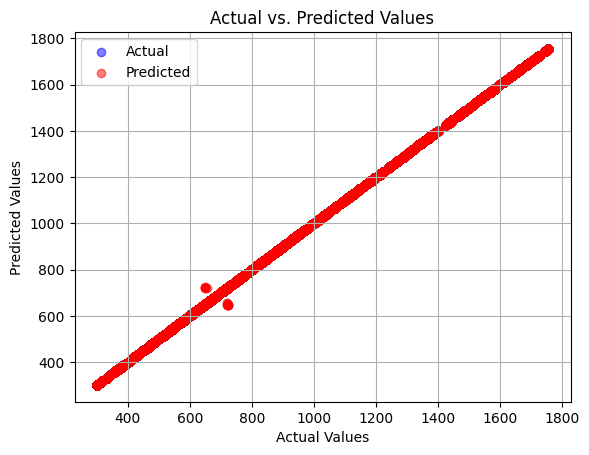

In [85]:
# Initialize the Decision Tree Regressor model
decision_tree_reg = DecisionTreeRegressor(random_state=42)

# Fit the model on the training data
decision_tree_reg.fit(X_train1, y_train1)

# Make predictions on the test data
y_pred_decision = decision_tree_reg.predict(X_test1)

# Evaluate the model
mse_dt = mean_squared_error(y_test1, y_pred_decision)
rmse_dt = mse_dt**0.5
mae_dt = mean_absolute_error(y_test1, y_pred_decision)
r2_dt = r2_score(y_test1, y_pred_decision)
adj_r2_dt = 1 - ((1 - r2_dt) * (n - 1) / (n - p - 1))

plt.scatter(y_test1, y_test1, c='b', label='Actual', alpha=0.5)  # Blue for actual
plt.scatter(y_test1, y_pred_decision, c='r', label='Predicted', alpha=0.5)  # Red for predicted
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

**Model Evaluation**

In [86]:
model = pd.DataFrame([['Decision Tree Baseline',  mse_dt,rmse_dt,mae_dt, r2_dt,adj_r2_dt]],
               columns = ['Model', 'MSE', 'RMSE', 'MAE', 'R2','adj_r2'])

model_result = pd.concat([model_result,model],axis=0,ignore_index = True)
model_result

,Model,MSE,RMSE,MAE,R2,adj_r2
0,Linear Regression Baseline,47023.080700,216.848059,165.358445,0.643141,0.642963
1,Linear Regression Tuned,47023.080700,216.848059,165.358445,0.643141,0.642963
2,Lasso Regression Baseline,47029.902715,216.863788,165.627117,0.643089,0.642912
3,Lasso Regression Tuned,47022.986109,216.847841,165.360732,0.643141,0.642964
4,Ridge Regression Baseline,47023.078125,216.848053,165.358494,0.643141,0.642963
5,Ridge Regression Tuned,47023.029642,216.847941,165.359413,0.643141,0.642964
6,ElasticNet Baseline,53547.622185,231.403592,184.529637,0.593626,0.593424
7,ElasticNet Tuned,47022.603924,216.846960,165.492006,0.643144,0.593424
8,Decision Tree Baseline,1.462788,1.209458,0.020189,0.999989,0.999989


**Hyperparameter tunning**

In [87]:
# Define hyperparameters and their potential values
param_grid_dt = {
    'criterion': ['friedman_mse', 'squared_error'],
    'max_depth': [15,30,45],
    'min_samples_split': [2,3,5],
    'max_features': [15,27,'sqrt'],
    'ccp_alpha' :[1,2]
}


# Create a GridSearchCV object for Decision Tree Regressor
grid_search_dt = GridSearchCV(decision_tree_reg, param_grid_dt, cv=3, scoring='neg_mean_squared_error')
grid_search_dt.fit(X_train1, y_train1)

# Get the best hyperparameters for Decision Tree Regressor
best_decision_tree_model = grid_search_dt.best_estimator_

In [88]:
grid_search_dt.best_estimator_

DecisionTreeRegressor(ccp_alpha=1, max_depth=30, max_features=27,
                      random_state=42)

In [89]:
# Print the best hyperparameters
print("Best Hyperparameters for Decision Tree:", grid_search_dt.best_estimator_)

Best Hyperparameters for Decision Tree: DecisionTreeRegressor(ccp_alpha=1, max_depth=30, max_features=27,
                      random_state=42)


**Model Evaluation**

In [90]:
# Evaluate the best model
y_pred_dt_tuned = best_decision_tree_model.predict(X_test1)

mae_dt_tuned = mean_absolute_error(y_test1, y_pred_dt_tuned)
mse_dt_tuned = mean_squared_error(y_test1, y_pred_dt_tuned)
rmse_dt_tuned = np.sqrt(mse_dt_tuned)
r2_dt_tuned = r2_score(y_test1, y_pred_dt_tuned)
adj_r2_dt_tuned = 1 - ((1 - r2_dt_tuned) * (n - 1) / (n - p - 1))

model = pd.DataFrame([['Decision Tree Tuned',  mse_dt_tuned,rmse_dt_tuned,mae_dt_tuned, r2_dt_tuned,adj_r2_dt_tuned]],
               columns = ['Model', 'MSE', 'RMSE', 'MAE', 'R2','adj_r2'])

model_result = pd.concat([model_result,model],axis=0,ignore_index = True)
model_result

,Model,MSE,RMSE,MAE,R2,adj_r2
0,Linear Regression Baseline,47023.080700,216.848059,165.358445,0.643141,0.642963
1,Linear Regression Tuned,47023.080700,216.848059,165.358445,0.643141,0.642963
2,Lasso Regression Baseline,47029.902715,216.863788,165.627117,0.643089,0.642912
3,Lasso Regression Tuned,47022.986109,216.847841,165.360732,0.643141,0.642964
4,Ridge Regression Baseline,47023.078125,216.848053,165.358494,0.643141,0.642963
5,Ridge Regression Tuned,47023.029642,216.847941,165.359413,0.643141,0.642964
6,ElasticNet Baseline,53547.622185,231.403592,184.529637,0.593626,0.593424
7,ElasticNet Tuned,47022.603924,216.846960,165.492006,0.643144,0.593424
8,Decision Tree Baseline,1.462788,1.209458,0.020189,0.999989,0.999989
9,Decision Tree Tuned,44.428859,6.665498,4.023163,0.999663,0.999663


**Feature Importance Decision Tree**

In [91]:
# Get feature importances
feature_importances_dt_reg = best_decision_tree_model.feature_importances_

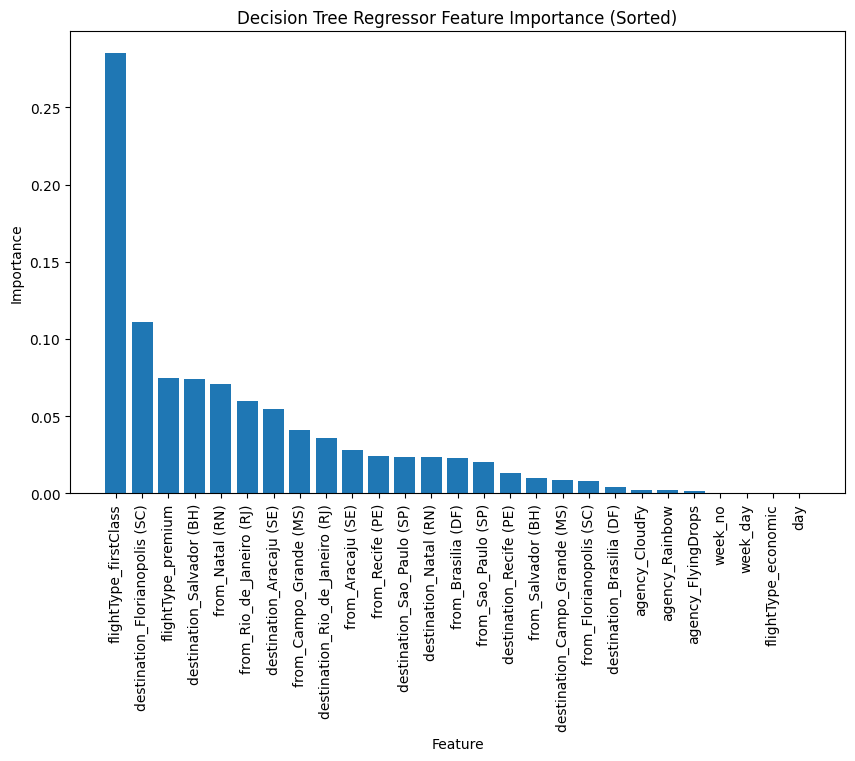

In [92]:
import matplotlib.pyplot as plt

# Define feature names
feature_names = X1.columns.tolist()  # Assuming X_train is a DataFrame

# Zip feature names and importances
feature_importances_sorted = sorted(zip(feature_names, feature_importances_dt_reg), key=lambda x: x[1], reverse=True)
sorted_features, sorted_importances = zip(*feature_importances_sorted)

# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_importances)), sorted_importances, align='center')
plt.xticks(range(len(sorted_importances)), sorted_features, rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Decision Tree Regressor Feature Importance (Sorted)')
plt.show()

**Random Forest**

**Baseline Model**

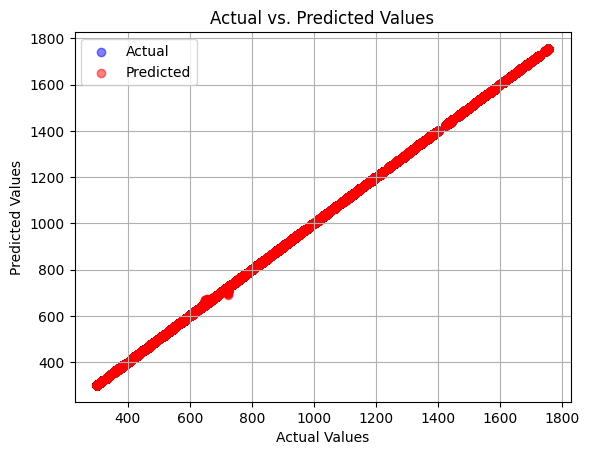

In [93]:
# Create and train the Linear Regression model
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train1, y_train1)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test1)

# Evaluate the model
mae_rf = mean_absolute_error(y_test1,y_pred_rf)
mse_rf = mean_squared_error(y_test1, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test1, y_pred_rf)
adj_r2_rf = 1 - ((1 - r2_rf) * (n - 1) / (n - p - 1))



plt.scatter(y_test1, y_test1, c='b', label='Actual', alpha=0.5)  # Blue for actual
plt.scatter(y_test1, y_pred_rf, c='r', label='Predicted', alpha=0.5)  # Red for predicted
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

**Model Evaluation**

In [94]:
model = pd.DataFrame([['Random Forest Baseline',  mse_rf,rmse_rf,mae_rf, r2_rf,adj_r2_rf]],
               columns = ['Model', 'MSE', 'RMSE', 'MAE', 'R2','adj_r2'])

model_result = pd.concat([model_result,model],axis=0,ignore_index = True)
model_result

,Model,MSE,RMSE,MAE,R2,adj_r2
0,Linear Regression Baseline,47023.080700,216.848059,165.358445,0.643141,0.642963
1,Linear Regression Tuned,47023.080700,216.848059,165.358445,0.643141,0.642963
2,Lasso Regression Baseline,47029.902715,216.863788,165.627117,0.643089,0.642912
3,Lasso Regression Tuned,47022.986109,216.847841,165.360732,0.643141,0.642964
4,Ridge Regression Baseline,47023.078125,216.848053,165.358494,0.643141,0.642963
5,Ridge Regression Tuned,47023.029642,216.847941,165.359413,0.643141,0.642964
6,ElasticNet Baseline,53547.622185,231.403592,184.529637,0.593626,0.593424
7,ElasticNet Tuned,47022.603924,216.846960,165.492006,0.643144,0.593424
8,Decision Tree Baseline,1.462788,1.209458,0.020189,0.999989,0.999989
9,Decision Tree Tuned,44.428859,6.665498,4.023163,0.999663,0.999663


**Hyperparameter tunning**

In [95]:
# Define hyperparameters and their potential values
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [1,5,10],
    'min_samples_split': [2, 5,10],
    'max_features': ['sqrt',27],
    'n_jobs': [2]


}

# Create a GridSearchCV object for Random Forest Regression
grid_search_rf = GridSearchCV(rf_model, param_grid_rf, cv=3, scoring='neg_mean_squared_error')
grid_search_rf.fit(X_train1, y_train1)

# Get the best hyperparameters for Random Forest Regression
best_rf_model = grid_search_rf.best_estimator_

In [96]:
grid_search_rf.best_estimator_

RandomForestRegressor(max_depth=10, max_features=27, n_estimators=50, n_jobs=2,
                      random_state=42)

In [97]:
# Print the best hyperparameters
print("Best Hyperparameters for Random Forest:", grid_search_rf.best_estimator_)

Best Hyperparameters for Random Forest: RandomForestRegressor(max_depth=10, max_features=27, n_estimators=50, n_jobs=2,
                      random_state=42)


**Model Evaluation**

In [98]:
# Evaluate the best model
y_pred_rf_tuned = best_rf_model.predict(X_test1)

mae_rf_tuned = mean_absolute_error(y_test1, y_pred_rf_tuned)
mse_rf_tuned = mean_squared_error(y_test1, y_pred_rf_tuned)
rmse_rf_tuned = np.sqrt(mse_rf_tuned)
r2_rf_tuned = r2_score(y_test1, y_pred_rf_tuned)
adj_r2_rf_tuned = 1 - ((1 - r2_rf_tuned) * (n - 1) / (n - p - 1))

model = pd.DataFrame([['Random Forest Tuned',  mse_rf_tuned,rmse_rf_tuned,mae_rf_tuned, r2_rf_tuned,adj_r2_rf_tuned]],
               columns = ['Model', 'MSE', 'RMSE', 'MAE', 'R2','adj_r2'])

model_result = pd.concat([model_result,model],axis=0,ignore_index = True)
model_result

,Model,MSE,RMSE,MAE,R2,adj_r2
0,Linear Regression Baseline,47023.080700,216.848059,165.358445,0.643141,0.642963
1,Linear Regression Tuned,47023.080700,216.848059,165.358445,0.643141,0.642963
2,Lasso Regression Baseline,47029.902715,216.863788,165.627117,0.643089,0.642912
3,Lasso Regression Tuned,47022.986109,216.847841,165.360732,0.643141,0.642964
4,Ridge Regression Baseline,47023.078125,216.848053,165.358494,0.643141,0.642963
5,Ridge Regression Tuned,47023.029642,216.847941,165.359413,0.643141,0.642964
6,ElasticNet Baseline,53547.622185,231.403592,184.529637,0.593626,0.593424
7,ElasticNet Tuned,47022.603924,216.846960,165.492006,0.643144,0.593424
8,Decision Tree Baseline,1.462788,1.209458,0.020189,0.999989,0.999989
9,Decision Tree Tuned,44.428859,6.665498,4.023163,0.999663,0.999663


**Feature Importance Random Forest**

In [99]:
feature_importances_rf_reg = best_rf_model.feature_importances_

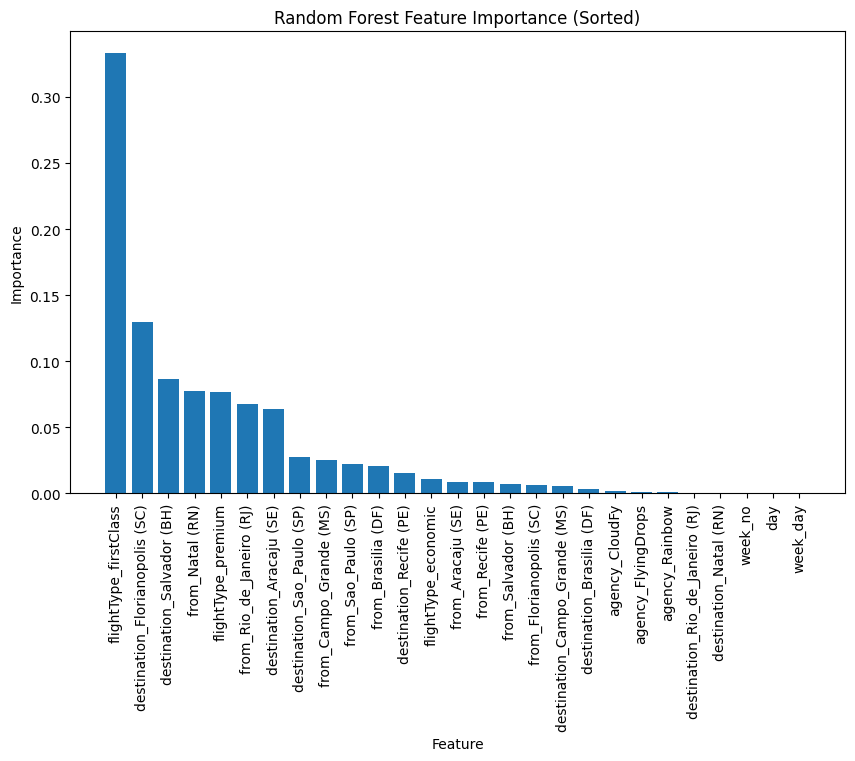

In [100]:
import matplotlib.pyplot as plt

# Define feature names
feature_names = X1.columns.tolist()  # Assuming X_train is a DataFrame

# Zip feature names and importances
feature_importances_sorted = sorted(zip(feature_names, feature_importances_rf_reg), key=lambda x: x[1], reverse=True)
sorted_features, sorted_importances = zip(*feature_importances_sorted)

# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_importances)), sorted_importances, align='center')
plt.xticks(range(len(sorted_importances)), sorted_features, rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Random Forest Feature Importance (Sorted)')
plt.show()

**XGBoost**

**Baseline Model**

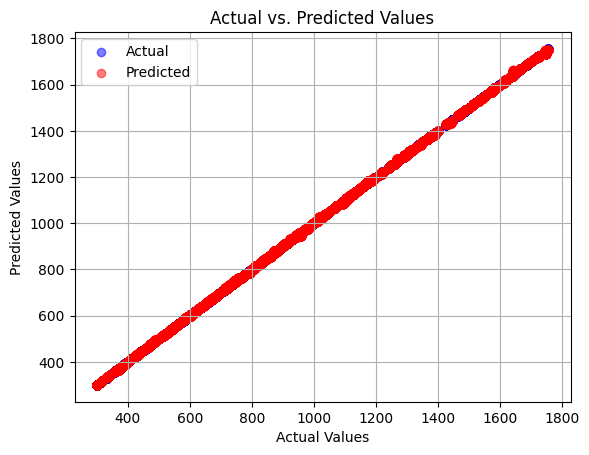

In [101]:
# Define Basic XGBoost regressor
xgb_regressor_model = XGBRegressor(random_state=42)
xgb_regressor_model.fit(X_train1, y_train1)

# Evaluate the model
y_pred_xgb = xgb_regressor_model.predict(X_test1)

mae_xgb = mean_absolute_error(y_test1, y_pred_xgb)
mse_xgb = mean_squared_error(y_test1,y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test1, y_pred_xgb)
adj_r2_xgb = 1 - ((1 - r2_xgb) * (n - 1) / (n - p - 1))

plt.scatter(y_test1, y_test1, c='b', label='Actual', alpha=0.5)  # Blue for actual
plt.scatter(y_test1, y_pred_xgb, c='r', label='Predicted', alpha=0.5)  # Red for predicted
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

**Model Evaluation**

In [102]:
model = pd.DataFrame([['XGBoost Baseline',  mse_xgb,rmse_xgb,mae_xgb, r2_xgb,adj_r2_xgb]],
               columns = ['Model', 'MSE', 'RMSE', 'MAE', 'R2','adj_r2'])

model_result = pd.concat([model_result,model],axis=0,ignore_index = True)
model_result

,Model,MSE,RMSE,MAE,R2,adj_r2
0,Linear Regression Baseline,47023.080700,216.848059,165.358445,0.643141,0.642963
1,Linear Regression Tuned,47023.080700,216.848059,165.358445,0.643141,0.642963
2,Lasso Regression Baseline,47029.902715,216.863788,165.627117,0.643089,0.642912
3,Lasso Regression Tuned,47022.986109,216.847841,165.360732,0.643141,0.642964
4,Ridge Regression Baseline,47023.078125,216.848053,165.358494,0.643141,0.642963
5,Ridge Regression Tuned,47023.029642,216.847941,165.359413,0.643141,0.642964
6,ElasticNet Baseline,53547.622185,231.403592,184.529637,0.593626,0.593424
7,ElasticNet Tuned,47022.603924,216.846960,165.492006,0.643144,0.593424
8,Decision Tree Baseline,1.462788,1.209458,0.020189,0.999989,0.999989
9,Decision Tree Tuned,44.428859,6.665498,4.023163,0.999663,0.999663


**Hyperparameter tunning**

In [103]:
# Define the hyperparameter grid for tuning
param_grid = {
    'n_estimators': [3,5],                # Number of boosting rounds
    'max_depth': [35,50],                          # Maximum depth of each tree
    'subsample': [0.6, 0.8, 1.0],                    # Subsample ratio of the training instances
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0.1, 0.3],
    'reg_alpha': [0, 0.5, 1.0]# Subsample ratio of columns when constructing each tree
     }

# Create a GridSearchCV object for XGBoost regression
grid_search_xgb = GridSearchCV(xgb_regressor_model, param_grid, cv=3, scoring='neg_mean_squared_error')

# Perform grid search
grid_search_xgb.fit(X_train1, y_train1)

# Get the best hyperparameters for XGBoost regression
best_xgb_regressor = grid_search_xgb.best_estimator_

In [104]:
grid_search_xgb.best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=35, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=5, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [105]:
# Print the best hyperparameters
print("Best Hyperparameters for XGBoost Regressor:", grid_search_xgb.best_estimator_)

Best Hyperparameters for XGBoost Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=35, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=5, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)


**Model Evaluation**

In [106]:
# Evaluate the best model
y_pred_xgb_tuned = best_xgb_regressor.predict(X_test1)

mae_xgb_tuned = mean_absolute_error(y_test1, y_pred_xgb_tuned)
mse_xgb_tuned = mean_squared_error(y_test1, y_pred_xgb_tuned)
rmse_xgb_tuned = np.sqrt(mse_xgb_tuned)
r2_xgb_tuned = r2_score(y_test1, y_pred_xgb_tuned)
adj_r2_xgb_tuned = 1 - ((1 - r2_xgb_tuned) * (n - 1) / (n - p - 1))

model = pd.DataFrame([['XGBosst Model Tuned',  mse_xgb_tuned,rmse_xgb_tuned,mae_xgb_tuned, r2_xgb_tuned,adj_r2_xgb_tuned]],
               columns = ['Model', 'MSE', 'RMSE', 'MAE', 'R2','adj_r2'])

model_result = pd.concat([model_result,model],axis=0,ignore_index = True)
model_result

,Model,MSE,RMSE,MAE,R2,adj_r2
0,Linear Regression Baseline,47023.080700,216.848059,165.358445,0.643141,0.642963
1,Linear Regression Tuned,47023.080700,216.848059,165.358445,0.643141,0.642963
2,Lasso Regression Baseline,47029.902715,216.863788,165.627117,0.643089,0.642912
3,Lasso Regression Tuned,47022.986109,216.847841,165.360732,0.643141,0.642964
4,Ridge Regression Baseline,47023.078125,216.848053,165.358494,0.643141,0.642963
5,Ridge Regression Tuned,47023.029642,216.847941,165.359413,0.643141,0.642964
6,ElasticNet Baseline,53547.622185,231.403592,184.529637,0.593626,0.593424
7,ElasticNet Tuned,47022.603924,216.846960,165.492006,0.643144,0.593424
8,Decision Tree Baseline,1.462788,1.209458,0.020189,0.999989,0.999989
9,Decision Tree Tuned,44.428859,6.665498,4.023163,0.999663,0.999663


In [107]:
y_pred_rf = best_xgb_regressor.predict(X_test1)
y_pred_rf_tr = best_xgb_regressor.predict(X_train1)

In [108]:
#Training data Metrics

mse_rf_tr = mean_squared_error(y_train1, y_pred_rf_tr)
rmse_rf_tr = np.sqrt(mse_rf_tr)
mae_rf_tr = mean_absolute_error(y_train1, y_pred_rf_tr)
r2_rf_tr = r2_score(y_train1, y_pred_rf_tr)
adj_r2_rf_tr = 1 - ((1 - r2_rf_tr) * (n - 1) / (n - p - 1))

#Test data Metrics
mse_rf = mean_squared_error(y_test1, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test1, y_pred_rf)
r2_rf = r2_score(y_test1, y_pred_rf)
adj_r2_rf = 1 - ((1 - r2_rf) * (n - 1) / (n - p - 1))

In [109]:
print("\nRandom Forest Regression Train Metrics:")
print("Mean Squared Error (MSE):", mse_rf_tr)
print("Root Mean Squared Error (RMSE):", rmse_rf_tr)
print("Mean Absolute Error (MAE):", mae_rf_tr)
print("R-squared (R2) Score:", r2_rf_tr)
print("Adjusted R-squared (Adj R2) Score:", adj_r2_rf_tr)


print("\nRandom Forest Regression Test Metrics:")
print("Mean Squared Error (MSE):", mse_rf)
print("Root Mean Squared Error (RMSE):", rmse_rf)
print("Mean Absolute Error (MAE):", mae_rf)
print("R-squared (R2) Score:", r2_rf)
print("Adjusted R-squared (Adj R2) Score:", adj_r2_rf)


Random Forest Regression Train Metrics:
Mean Squared Error (MSE): 3747.537574490705
Root Mean Squared Error (RMSE): 61.21713464783128
Mean Absolute Error (MAE): 51.289616034934234
R-squared (R2) Score: 0.9714243357857447
Adjusted R-squared (Adj R2) Score: 0.9714101399635959

Random Forest Regression Test Metrics:
Mean Squared Error (MSE): 3761.733410249294
Root Mean Squared Error (RMSE): 61.33297164045856
Mean Absolute Error (MAE): 51.39383525622922
R-squared (R2) Score: 0.9714521048688584
Adjusted R-squared (Adj R2) Score: 0.9714379228418383


**Feature Importance XGBoost**

In [110]:
feature_importances_xgb_reg = best_xgb_regressor.feature_importances_

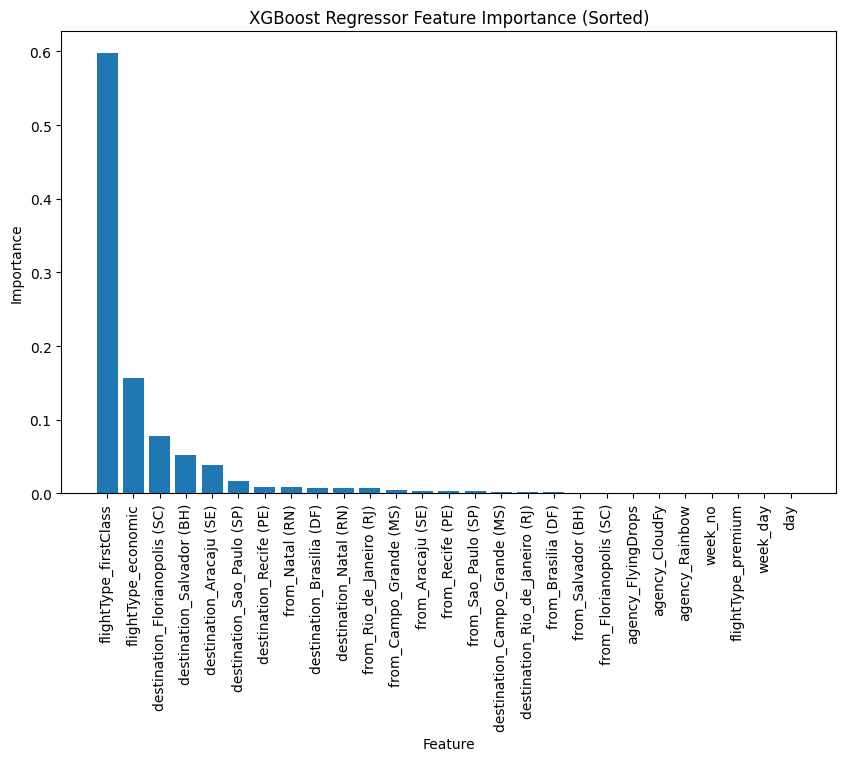

In [111]:
import matplotlib.pyplot as plt

# Define feature names
feature_names = X1.columns.tolist()  # Assuming X_train is a DataFrame

# Zip feature names and importances
feature_importances_sorted = sorted(zip(feature_names, feature_importances_xgb_reg), key=lambda x: x[1], reverse=True)
sorted_features, sorted_importances = zip(*feature_importances_sorted)

# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_importances)), sorted_importances, align='center')
plt.xticks(range(len(sorted_importances)), sorted_features, rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('XGBoost Regressor Feature Importance (Sorted)')
plt.show()

**Benchmark Models**

In [112]:
#Benchmark Model on the basis on RMSE metric
model_result[model_result['RMSE']==model_result['RMSE'].min()]

,Model,MSE,RMSE,MAE,R2,adj_r2
10,Random Forest Baseline,0.43459,0.659235,0.044337,0.999997,0.999997


In [113]:
#Benchmark Model on the basis on Adjusted R2 square metric
model_result[model_result['adj_r2']==model_result['adj_r2'].max()]

,Model,MSE,RMSE,MAE,R2,adj_r2
10,Random Forest Baseline,0.43459,0.659235,0.044337,0.999997,0.999997


In [114]:
#Benchmark Models on the basis of RMSE and adjusted R2 square metrics were as follows
filtered_result = model_result[(model_result['adj_r2'] == model_result['adj_r2'].max()) | (model_result['RMSE'] == model_result['RMSE'].min())]
filtered_result

,Model,MSE,RMSE,MAE,R2,adj_r2
10,Random Forest Baseline,0.43459,0.659235,0.044337,0.999997,0.999997


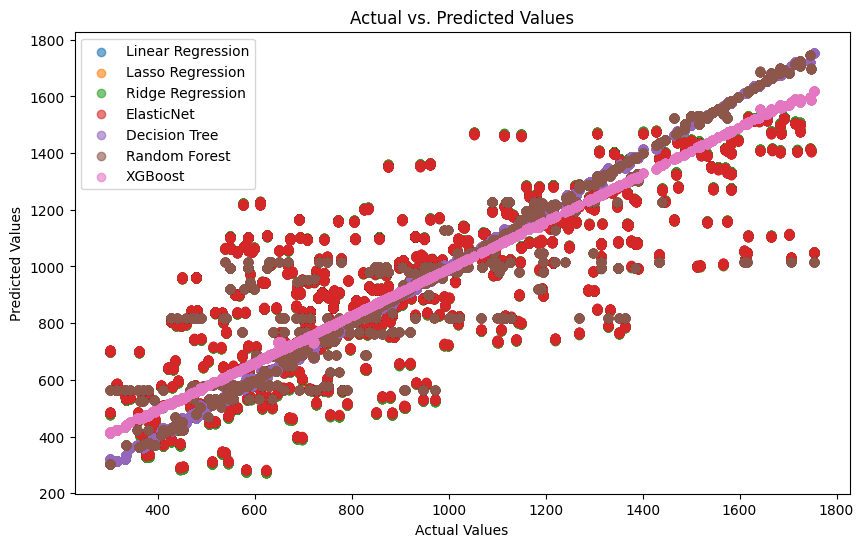

In [115]:
plt.figure(figsize=(10, 6))

# Linear Regression
plt.scatter(y_test1, y_pred_linear_tuned, label='Linear Regression', alpha=0.6)

# Lasso Regression
plt.scatter(y_test1, y_pred_lasso_tuned, label='Lasso Regression', alpha=0.6)

# Ridge Regression
plt.scatter(y_test1, y_pred_ridge_tuned, label='Ridge Regression', alpha=0.6)

# ElasticNet
plt.scatter(y_test1, y_pred_elastic_tuned, label='ElasticNet', alpha=0.6)

# Decision Tree Regressor
plt.scatter(y_test1, y_pred_dt_tuned, label='Decision Tree', alpha=0.6)

# Random Forest Regressor
plt.scatter(y_test1, y_pred_rf_tuned, label='Random Forest', alpha=0.6)

# XGBoost Regressor
plt.scatter(y_test1, y_pred_xgb_tuned, label='XGBoost', alpha=0.6)

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.show()

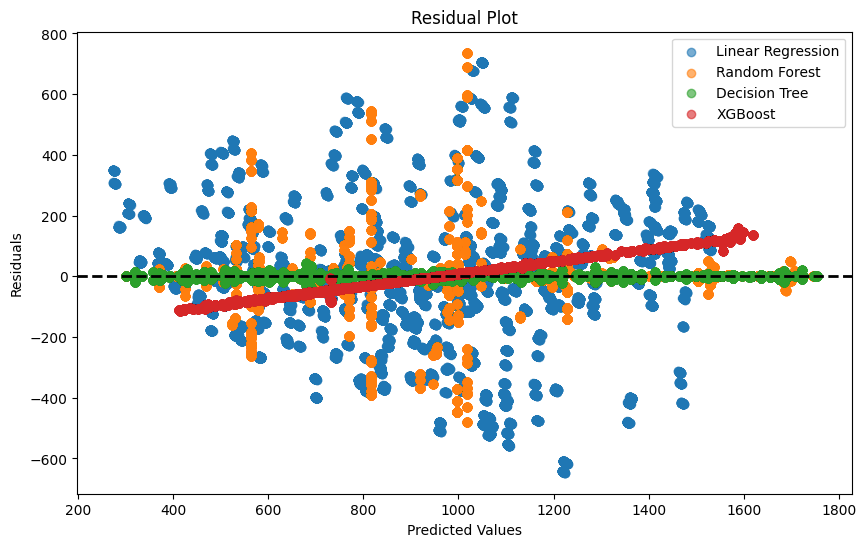

In [116]:
plt.figure(figsize=(10, 6))

# Linear Regression Residuals
residuals_lr = y_test1 - y_pred_linear_tuned
plt.scatter(y_pred_linear_tuned, residuals_lr, label='Linear Regression', alpha=0.6)

# Random Forest Regressor Residuals
residuals_rf = y_test1 - y_pred_rf_tuned
plt.scatter(y_pred_rf_tuned, residuals_rf, label='Random Forest', alpha=0.6)

# Decision Tree Regressor Residuals
residuals_dt = y_test1 -y_pred_dt_tuned
plt.scatter(y_pred_dt_tuned, residuals_dt, label='Decision Tree', alpha=0.6)

# XGBoost Regressor Residuals
residuals_xgb = y_test1 -y_pred_xgb_tuned
plt.scatter(y_pred_xgb_tuned, residuals_xgb, label='XGBoost', alpha=0.6)

plt.axhline(0, color='black', linestyle='--', lw=2)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.legend()
plt.show()

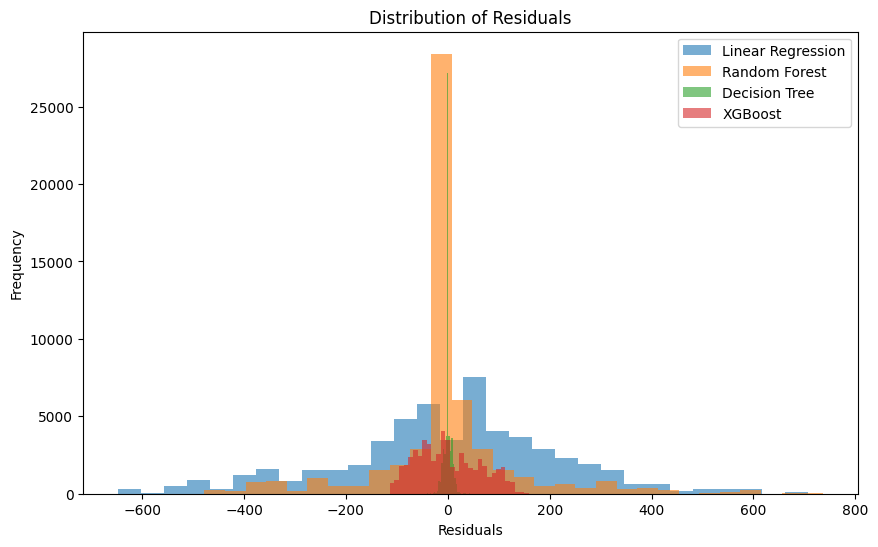

In [117]:
plt.figure(figsize=(10, 6))

# Linear Regression Residuals Distribution
plt.hist(residuals_lr, bins=30, alpha=0.6, label='Linear Regression')

# Random Forest Regressor Residuals Distribution
plt.hist(residuals_rf, bins=30, alpha=0.6, label='Random Forest')

# Decision Tree Regressor Residuals Distribution
plt.hist(residuals_dt, bins=30, alpha=0.6, label='Decision Tree')

# XGBoost Regressor Residuals Distribution
plt.hist(residuals_xgb, bins=30, alpha=0.6, label='XGBoost')

plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")
plt.legend()
plt.show()

**Feature Selection Using Multicollinearity and Vif Score**

In [118]:
#Multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [119]:
final_df= flight_filtered_df.drop(columns=['flight_speed','time','month','year','distance'],axis=1)

In [120]:
correlation_matrix = final_df.corr()
k = 27 # Replace with the desired number of top features
selected_features = correlation_matrix['price'].abs().sort_values(ascending=False).index[1:k+1]

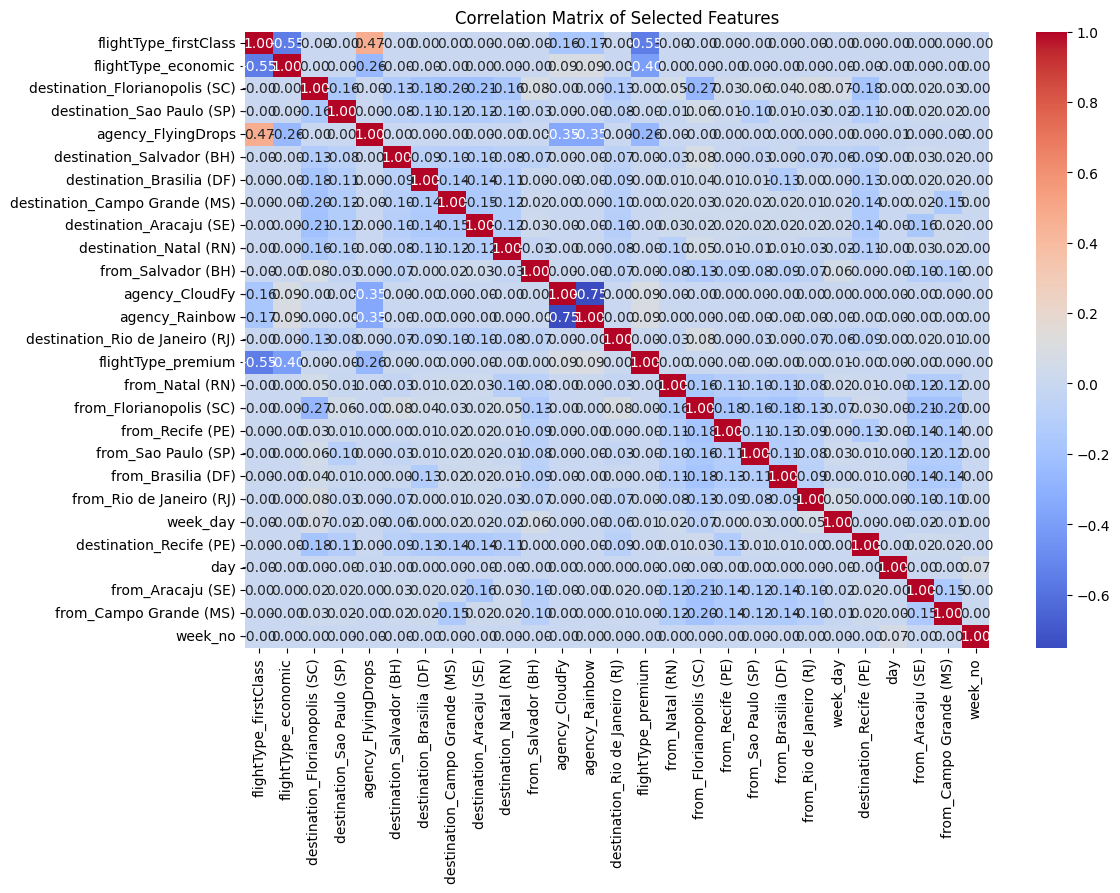

In [121]:
# Create a subset of the DataFrame with the selected features
subset_df = final_df[selected_features]

# Calculate the correlation matrix for the selected features
correlation_matrix = subset_df.corr()

# Set up the plot figure size
plt.figure(figsize=(12, 8))

# Create a heatmap of the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Set the plot title
plt.title('Correlation Matrix of Selected Features')

# Show the plot
plt.show()

**Flask Building**

Things we need to do:

**Flask Web Application:** We create a Flask web application to serve as an API endpoint.

**Load Trained Model:** We load a trained regression model (you should replace this with your actual model loading code).

**Prediction Function:** We define a function (predict_value) to make predictions using the loaded model.

**User Input Processing:** In the /predict route, we collect user input data from an HTML form, including price, travel details, and other parameters.

**Data Preparation:** We prepare the user input data and convert it into a format suitable for making predictions.

**Prediction:** Using the loaded model, we make predictions based on the user's input.

**JSON Response:** We return the prediction result as a JSON response to the API request.

**HTML Form:** If the request is a GET request, we display an HTML form to collect user input.

**Styling:** You can customize the HTML form and add CSS styling to make it visually appealing.

**Run the Flask App:** The Flask app is run, allowing users to access it and receive predictions through API requests.

In [122]:
import pickle
pickle.dump(scaler_new,open('scaling.pkl','wb'))
pickle.dump(best_rf_model,open('rf_model.pkl','wb'))

In [123]:
pickle.dump(best_linear_reg,open('lr_model.pkl','wb'))
pickle.dump(best_lasso_model,open('lasso_model.pkl','wb'))
pickle.dump(best_ridge_model,open('ridge_model.pkl','wb'))
pickle.dump(best_elasticnet_model,open('elasticnet_model.pkl','wb'))
pickle.dump(best_decision_tree_model,open('dt_model.pkl','wb'))
pickle.dump(best_xgb_regressor,open('xgb_model.pkl','wb'))

In [124]:
with open("scaling.pkl", "wb") as f:
    pickle.dump(scaler_new, f)

In [125]:
scaler_model=pickle.load(open('scaling.pkl','rb'))
rf_model=pickle.load(open('rf_model.pkl','rb'))

In [126]:
# Create a function for prediction
def predict_price(input_data, model,scaler):
    # Prepare the input data

    # Initialize an empty DataFrame
    df_input2 = pd.DataFrame([input_data])

    # Independent features
    X = df_input2

    # Scale the data using the same scaler used during training
    X = scaler.transform(X)

    # Make predictions using the trained Decision model
    y_pred = model.predict(X)

    return y_pred[0]

**Testing Pickled model**

In [1]:
import pandas as pd

df_input = pd.read_csv(flights_file_path,on_bad_lines='skip')


df_input['date'] = pd.to_datetime(df_input['date'])
df_input['day'] = df_input['date'].dt.day
df_input['week_no'] = df_input['date'].dt.isocalendar().week # Use isocalendar().week to get week number
df_input['week_day'] = df_input['date'].dt.weekday

# renaming the Column name
df_input.rename(columns={"to":"destination"},inplace=True)

# one-hot encoding
df_input = pd.get_dummies(df_input, columns=['from','destination','flightType','agency'])

# renaming the Column name
df_input.rename(columns={'from_Sao Paulo (SP)':'from_Sao_Paulo (SP)','from_Rio de Janeiro (RJ)':'from_Rio_de_Janeiro (RJ)','from_Campo Grande (MS)':'from_Campo_Grande (MS)',
                                  'destination_Sao Paulo (SP)':'destination_Sao_Paulo (SP)','destination_Rio de Janeiro (RJ)':'destination_Rio_de_Janeiro (RJ)','destination_Campo Grande (MS)':'destination_Campo_Grande (MS)'},inplace=True)

NameError: name 'flights_file_path' is not defined

In [ ]:
#ordering features based on requirement
Z=df_input[X1.columns]

In [ ]:
#Edited Code
row_index = 10  # Replace with the desired row index

# Access the row from df_input using iloc
input_row = Z.iloc[row_index]

# Create an input dictionary from the selected row
input_data = Z.iloc[row_index].to_dict()
scaler_model_new1=pickle.load(open('scaling.pkl','rb'))
rf_model_new1=pickle.load(open('dt_model.pkl','rb'))
predicted_price = str(round(predict_price(input_data, rf_model,scaler_model),2))
print(f'Predicted Flight Price Per Person: ${predicted_price}')